# Property Data Analysis
The purpose of this notebook is to explore data sourced from njpropertyrecords.com and analyze which features can be used to model a vector search and predict property values.

# Loading Sample Data
First we'll load a sample property file from our workspace

In [1]:
import json
import pandas as pd
import os

current_directory = os.getcwd()
print(current_directory)

/Users/jleelong/workspace/sample-similarity-search


In [2]:
def remove_na_attributes(data):
    """
    Recursively removes attributes with NA values from a JSON-like dictionary.

    Args:
        data (dict): A dictionary representing JSON data.

    Returns:
        dict: A new dictionary with NA attributes removed.
    """
    if isinstance(data, dict):
        return {
            k: remove_na_attributes(v) for k, v in data.items() if v is not None and v != "NA"
        }
    elif isinstance(data, list):
        return [remove_na_attributes(item) for item in data]
    else:
        return data


def load_json_files_to_dataframe(file_dir):
    """
    Loads multiple JSON files from a directory into a single Pandas DataFrame.

    Args:
        file_dir (str): The directory containing the JSON files.

    Returns:
        pd.DataFrame: A DataFrame containing the combined data from all JSON files.
                      Returns an empty DataFrame if no files are found or if an error occurs.
    """
    all_files = os.listdir(file_dir)
    json_files = [f for f in all_files if f.endswith('.json')]
    
    if not json_files:
        print(f"No JSON files found in directory: {file_dir}")
        return pd.DataFrame()

    all_data = []
    for file_name in json_files:
        file_path = os.path.join(file_dir, file_name)
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                all_data.append(data)
        except json.JSONDecodeError:
            print(f"Error decoding JSON in file: {file_path}")
        except FileNotFoundError:
             print(f"File not found: {file_path}")

    if not all_data:
        return pd.DataFrame()
    
    if not isinstance(all_data, list):
         return pd.DataFrame()

    all_data = remove_na_attributes(all_data)
    return pd.concat([pd.json_normalize(data) for data in all_data], ignore_index=True)

In [3]:
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
    
file_directory = 'data/sample' 
df = load_json_files_to_dataframe(file_directory)

df.head()

,id,address,houseNumber,$$scrambled,$$scrambledKeys,countyData.GIS_PIN,countyData.Census_State,countyData.Census_County,countyData.Census_Tract,countyData.Census_Block,countyData.Census_Code,countyData.Electric_Provider,countyData.Gas_Provider,countyData.Sewer_Service_Area,countyData.Water_Provider,countyData.No_Of_Dwellings,countyData.APN,countyData.COUNTY_NAME,countyData.DISTRICT_NAME,countyData.Municipality,countyData.Block,countyData.Lot,countyData.Owners_Name,countyData.Owners_Mailing_Address,countyData.Property_Location,countyData.City_State_Zip,countyData.Corporate_Owned,countyData.Absentee,countyData.Deed_Book,countyData.Deed_Page,countyData.Sale_Date,countyData.Sale_Price,countyData.NU_Code,countyData.Acreage,countyData.Map_Page,countyData.Sq_Ft,countyData.Property_Class,countyData.Building_Class,countyData.Land_Desc,countyData.Building_Desc,countyData.Class_4_Code,countyData.Yr_Built,countyData.Zone,countyData.Additional_Lots,countyData.Additional_Lots_Parsed,countyData.TaxRate,countyData.TaxRatio,countyData.RateYear,countyData.RatioYear,countyData.Recorded_Taxes,countyData.Recorded_Taxes_Year,countyData.Calculated_Taxes,countyData.Calculated_Taxes_Year,countyData.Veterans_CNT,countyData.Senior_Citizens_CNT,countyData.Widows_CNT,countyData.Surv_Spouse_CNT,countyData.Disabled_CNT,countyData.Deduction_Amount,countyData.Year_1,countyData.Land_Assmnt_1,countyData.Building_Assmnt_1,countyData.Total_Assmnt_1,countyData.Year_2,countyData.Land_Assmnt_2,countyData.Building_Assmnt_2,countyData.Total_Assmnt_2,countyData.O_City,countyData.O_State,countyData.O_Zip,countyData.P_City,countyData.P_State,countyData.P_Zip,countyData.Prop_Mail_HouseNum,countyData.Prop_Mail_StreetName,countyData.Prop_Mail_Suffix,countyData.Prop_Mail_City,countyData.Prop_Mail_State,countyData.Prop_Mail_Zip,countyData.Prop_Mail_Zip4,countyData.Prop_Mail_Street,countyData.Prop_Mail_CRRT,countyData.Prop_Mail_DPV,countyData.Prop_Mail_USPSBarCode,countyData.Prop_Mail_LineOfTravel,countyData.Prop_Mail_Deliverable,countyData.Prop_Mail_CMRA,countyData.Prop_Mail_VacantStatus,countyData.Prop_Mail_NoStats,countyData.Prop_Mail_PBSA,countyData.Prop_Mail_RDI,countyData.Prop_Mail_Corrections,countyData.Prop_Mail_ResultCode,countyData.Owner_Mail_HouseNum,countyData.Owner_Mail_StreetName,countyData.Owner_Mail_Suffix,countyData.Owner_Mail_City,countyData.Owner_Mail_State,countyData.Owner_Mail_Zip,countyData.Owner_Mail_Zip4,countyData.Owner_Mail_Street,countyData.Owner_Mail_CRRT,countyData.Owner_Mail_DPV,countyData.Owner_Mail_USPSBarCode,countyData.Owner_Mail_LineOfTravel,countyData.Owner_Mail_Deliverable,countyData.Owner_Mail_CMRA,countyData.Owner_Mail_VacantStatus,countyData.Owner_Mail_NoStats,countyData.Owner_Mail_PBSA,countyData.Owner_Mail_RDI,countyData.Owner_Mail_Corrections,countyData.Owner_Mail_ResultCode,countyData.Direct_Parties,countyData.Reverse_Parties,countyData.updated_at,countyData.TotalUnits,recordData.Bed,recordData.Eff_Age,recordData.Info_By,recordData.Fireplace,recordData.Foundation,recordData.Total_Rooms,recordData.Attached_Items,recordData.Detached_Items,recordData.First_Floor_Sqft,recordData.Layout_Condition,recordData.Attic_Finish_Sqft,recordData.Half_Stories_Sqft,recordData.Exterior_Condition,recordData.Interior_Condition,recordData.Upper_Stories_Sqft,recordData.Basement_Finish_Sqft,recordData.Basement_Unfinished_Sqft,location.lat,location.lng,parcelCentroid.lat,parcelCentroid.lng,rooftop.lat,rooftop.lng,countyData.Owner_Mail_ErrorCode,countyData.Owner_Mail_SUD,countyData.Owner_Mail_UnitNum,countyData.Owner_Mail_PreDir,countyData.Owner_Mail_FalsePositive,recordData.Style,recordData.Height,recordData.Air_Cond,recordData.Heat_Src,recordData.Heat_Sys,recordData.Plumbing,recordData.Roof_Type,recordData.Floor_Finish,recordData.Roof_Material,recordData.Exterior_Finish,recordData.Interior_Finish,countyData.Prop_Mail_ErrorCode,countyData.Prop_Mail_FalsePositive,countyData.Owner_Mail_PostDir,countyData.Prop_Mail_PreDir,countyData.PRIOR_GIS_PIN,countyData.Pr

First we'll drop any records that are misisng a sales price since we cannot use that data for training.

In [4]:
df = df.dropna(subset=['countyData.Sale_Price'])
len(df)

118233

# Feature Selection
Next we'll investigate the data in the file to identify relevant features that we'll want to use

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

**I'm going to exclude address fields since the information is encoded in the geolocation**

      "countyData.Property_Location": "119 Fells Road",
      "countyData.COUNTY_NAME": "Essex",
      "countyData.DISTRICT_NAME": "Essex Fells Borough",
      "countyData.P_City": "Essex Fells",
      "countyData.P_State": "NJ",
      "countyData.P_Zip": "07021",

**And include the following columns for our feature set**

      "location.lat": 40.832978,
      "location.lng": -74.2639852,
      
      "countyData.Number_Of_Owners": 2,
      "countyData.No_Of_Dwellings": 1,
      "countyData.Corporate_Owned": false,
      "countyData.Absentee": 0,
      "countyData.NU_Code": "26",
      "countyData.updated_at": "2025-01-12T18:26:19.000Z",
      "countyData.TotalUnits": 1,
      
      "countyData.Acreage": 0.3145,
      "countyData.Sq_Ft": 2612,
      "countyData.Property_Class": "2",
      "countyData.Building_Class": "19",
      "countyData.Yr_Built": 1936,
      "countyData.Sale_Date": "2022-06-14T00:00:00.000Z",
      
      "countyData.TaxRate": "2.164",
      "countyData.TaxRatio": "93.46",
      "countyData.RateYear": "2024",
      "countyData.RatioYear": "2024",
      "countyData.Recorded_Taxes": 15746.18,
      "countyData.Recorded_Taxes_Year": 2023,
      "countyData.Calculated_Taxes": 15717.13,
      "countyData.Calculated_Taxes_Year": 2024,
      
      "countyData.Year_1": 2025,
      "countyData.Land_Assmnt_1": 410400,
      "countyData.Building_Assmnt_1": 315900,
      "countyData.Total_Assmnt_1": 726300,
      "countyData.Year_2": 2024,
      "countyData.Land_Assmnt_2": 410400,
      "countyData.Building_Assmnt_2": 315900,
      "countyData.Total_Assmnt_2": 726300,

      "recordData.Bed": "8",
      "recordData.Eff_Age": 7720,
      "recordData.Total_Rooms": "85",

**And our target label**

      "countyData.Sale_Price": 170000,

**Then we'll reduce the dataframe to these features before continuing with the analysis**

In [6]:
columns_to_keep = ['id', 'location.lat', 'location.lng', 'countyData.Number_Of_Owners', 'countyData.No_Of_Dwellings',
                   'countyData.Corporate_Owned', 'countyData.Absentee', 'countyData.NU_Code', 'countyData.updated_at',
                   'countyData.TotalUnits', 'countyData.Acreage', 'countyData.Sq_Ft', 'countyData.Property_Class',
                   'countyData.Building_Class', 'countyData.Yr_Built', 'countyData.Sale_Date', 'countyData.TaxRate',
                   'countyData.TaxRatio', 'countyData.RateYear', 'countyData.RatioYear', 'countyData.Recorded_Taxes',
                   'countyData.Recorded_Taxes_Year', 'countyData.Calculated_Taxes', 'countyData.Calculated_Taxes_Year',
                   'countyData.Year_1', 'countyData.Land_Assmnt_1', 'countyData.Building_Assmnt_1', 'countyData.Total_Assmnt_1',
                   'countyData.Year_2', 'countyData.Land_Assmnt_2', 'countyData.Building_Assmnt_2', 'countyData.Total_Assmnt_2',
                   'recordData.Bed', 'recordData.Eff_Age', 'recordData.Total_Rooms', 'countyData.Sale_Price']
df = df[columns_to_keep]
df = df.rename(columns={'location.lat': 'lat', 'location.lng': 'lng', 'countyData.Number_Of_Owners': 'Number_Of_Owners',
                        'countyData.No_Of_Dwellings': 'No_Of_Dwellings', 'countyData.Corporate_Owned': 'Corporate_Owned',
                        'countyData.Absentee': 'Absentee', 'countyData.NU_Code': 'NU_Code', 'countyData.updated_at': 'updated_at',
                        'countyData.TotalUnits': 'TotalUnits', 'countyData.Acreage': 'Acreage', 'countyData.Sq_Ft': 'Sq_Ft',
                        'countyData.Property_Class': 'Property_Class', 'countyData.Building_Class': 'Building_Class',
                        'countyData.Yr_Built': 'Yr_Built', 'countyData.Sale_Date': 'Sale_Date', 'countyData.TaxRate': 'TaxRate',
                        'countyData.TaxRatio': 'TaxRatio', 'countyData.RateYear': 'RateYear', 'countyData.RatioYear': 'RatioYear',
                        'countyData.Recorded_Taxes': 'Recorded_Taxes', 'countyData.Recorded_Taxes_Year': 'Recorded_Taxes_Year',
                        'countyData.Calculated_Taxes': 'Calculated_Taxes', 'countyData.Calculated_Taxes_Year': 'Calculated_Taxes_Year',
                        'countyData.Year_1': 'Year_1', 'countyData.Land_Assmnt_1': 'Land_Assmnt_1',
                        'countyData.Building_Assmnt_1': 'Building_Assmnt_1', 'countyData.Total_Assmnt_1': 'Total_Assmnt_1',
                        'countyData.Year_2': 'Year_2', 'countyData.Land_Assmnt_2': 'Land_Assmnt_2',
                        'countyData.Building_Assmnt_2': 'Building_Assmnt_2', 'countyData.Total_Assmnt_2': 'Total_Assmnt_2',
                        'recordData.Bed': 'Bed', 'recordData.Eff_Age': 'Eff_Age', 'recordData.Total_Rooms': 'Total_Rooms',
                        'countyData.Sale_Price': 'Sale_Price'})
df.head()

,id,lat,lng,Number_Of_Owners,No_Of_Dwellings,Corporate_Owned,Absentee,NU_Code,updated_at,TotalUnits,Acreage,Sq_Ft,Property_Class,Building_Class,Yr_Built,Sale_Date,TaxRate,TaxRatio,RateYear,RatioYear,Recorded_Taxes,Recorded_Taxes_Year,Calculated_Taxes,Calculated_Taxes_Year,Year_1,Land_Assmnt_1,Building_Assmnt_1,Total_Assmnt_1,Year_2,Land_Assmnt_2,Building_Assmnt_2,Total_Assmnt_2,Bed,Eff_Age,Total_Rooms,Sale_Price
0,0121_113_1,39.326625,-74.584019,NaN,1.0,True,1,04,2025-02-02T17:02:52.000Z,125,3.7000,107676,4C,10,1970,2023-09-07T00:00:00.000Z,3.576,67.77,2024,2024,171660.9,2023.0,176904.72,2024.0,2025,1605000,3342000,4947000,2024,1605000,3342000,4947000,0,6270.0,0,10.0
1,0121_1229_1.02,39.329291,-74.608870,NaN,1.0,False,1,NaN,2025-02-02T17:02:52.000Z,0,8.5555,0,4C,10,1971,1997-01-06T00:00:00.000Z,3.576,67.77,2024,2024,306505.1,2023.0,315868.08,2024.0,2025,1800000,7033000,8833000,2024,1800000,7033000,8833000,0,7860.0,0,3870000.0
2,0121_1512_1,39.314255,-74.595032,NaN,4.0,False,1,NaN,2025-02-02T17:02:52.000Z,5,0.2858,6042,4C,45,1950,1983-03-15T00:00:00.000Z,3.576,67.77,2024,2024,17697.0,2023.0,18237.60,2024.0,2025,131300,378700,510000,2024,131300,378700,510000,8,8750.0,45,145000.0
3,0121_1815_1.01,39.310388,-74.598633,NaN,5.0,True,1,NaN,2025-02-02T17:02:52.000Z,12,0.3499,5010,4C,43,1940,2020-01-30T00:00:00.000Z,3.576,67.77,2024,2024,28141.7,2023.0,29001.36,2024.0,2025,228600,582400,811000,2024,228600,582400,811000,1,6726.0,14,650000.0
4,0121_2018_1.04,39.306754,-74.608589,NaN,1.0,True,2,NaN,2025-02-02T17:02:52.000Z,0,0.5404,0,4C,NaN,1960,2021-07-14T00:00:00.000Z,3.576,67.77,2024,2024,16309.0,2023.0,16807.20,2024.0,2025,289700,180300,470000,2024,289700,180300,470000,0,3300.0,0,1600000.0


In [7]:
print(df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Index: 118233 entries, 0 to 146947
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     118233 non-null  object 
 1   lat                    108121 non-null  float64
 2   lng                    108121 non-null  float64
 3   Number_Of_Owners       43528 non-null   float64
 4   No_Of_Dwellings        116996 non-null  float64
 5   Corporate_Owned        118233 non-null  bool   
 6   Absentee               118233 non-null  int64  
 7   NU_Code                69083 non-null   object 
 8   updated_at             118233 non-null  object 
 9   TotalUnits             118233 non-null  int64  
 10  Acreage                102021 non-null  float64
 11  Sq_Ft                  118233 non-null  int64  
 12  Property_Class         118233 non-null  object 
 13  Building_Class         101397 non-null  object 
 14  Yr_Built               118233 non-null  i

## County
We can parse the county from the id and store the value as an int to help with correlation, later we'll convert it to a categorical column.

In [8]:
df['County'] = df['id'].apply(lambda x: int(x[:2].lstrip("0")))
df['Municipality'] = df['id'].apply(lambda x: int(x[2:4].lstrip("0")))
df = df.drop('id', axis=1)

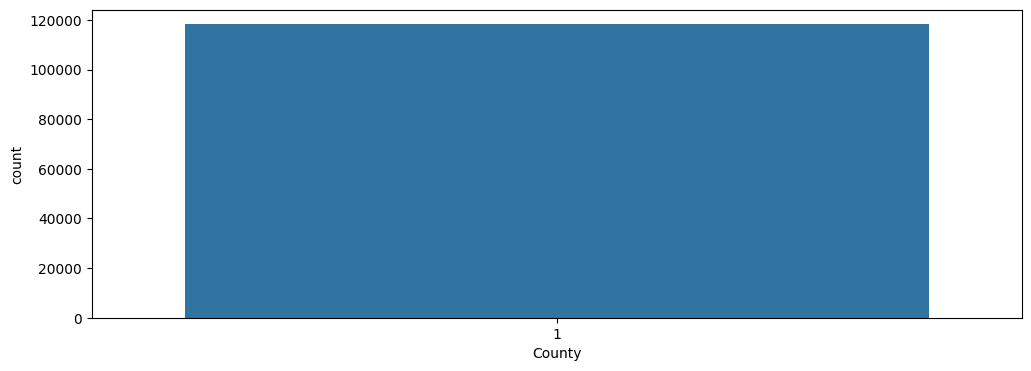

In [9]:
plt.figure(figsize=(12, 4))
sns.countplot(x='County', data=df, order=sorted(df['County'].unique()))
plt.show()

## NU Code
In New Jersey real estate tax appeals, "NU codes" refer to "Non-Usable" sales, meaning sales that are deemed unreliable for determining the true market value of a property for tax assessment purposes.  These include foreclosures, short sales, sales between family members, or properties damaged by fire / flood, among others.

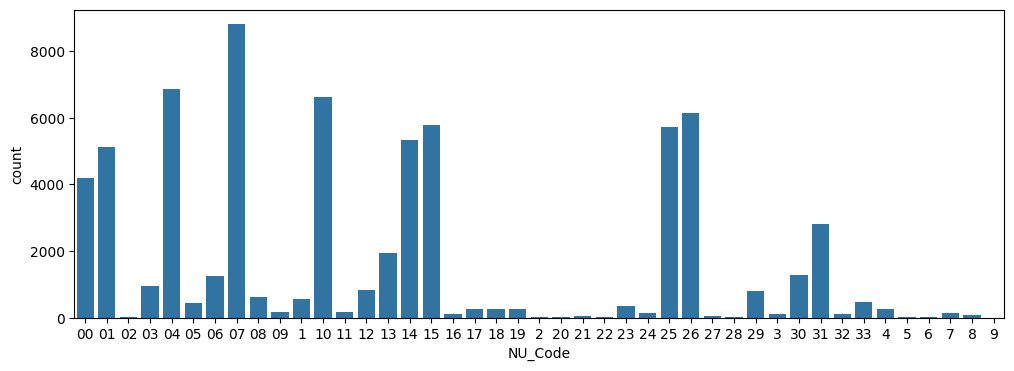

In [10]:
plt.figure(figsize=(12, 4))
sns.countplot(x='NU_Code', data=df, order=sorted(df['NU_Code'].dropna().unique()))
plt.show()

In [11]:
pd.options.display.float_format = '{:,.2f}'.format
df.groupby('NU_Code')['Sale_Price'].agg(['mean', 'count']).rename(columns={'mean': 'Average Value', 'count': 'Count of Sales'})

,Average Value,Count of Sales
NU_Code,,
00,"320,612.63",4179
01,"52,620.73",5126
02,"52,193.46",26
03,"125,527.57",938
04,"48,102.93",6872
05,"121,562.79",440
06,"3,854,874.12",1254
07,"400,974.74",8808
08,"51,546.22",621


In [12]:
df['NU_Code'] = df['NU_Code'].apply(lambda x: int(x) if pd.notna(x) and x.isdigit() else -1 if pd.notna(x) else 99)

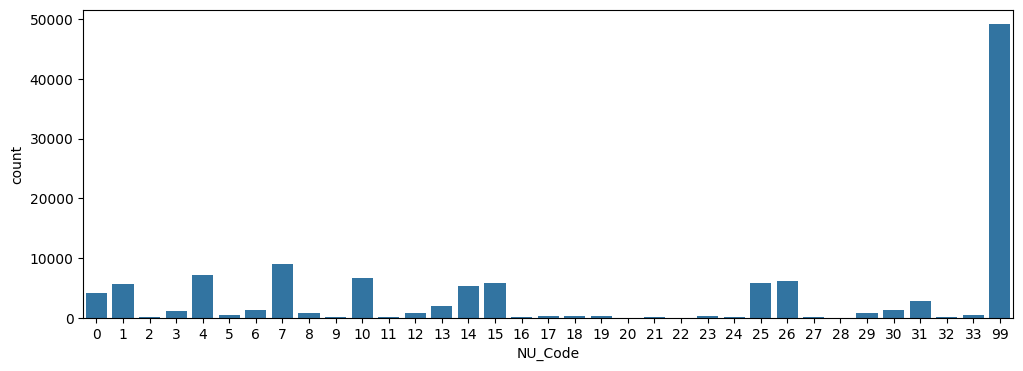

In [13]:
plt.figure(figsize=(12, 4))
sns.countplot(x='NU_Code', data=df, order=sorted(df['NU_Code'].unique()))
plt.show()

## Updated At
We probably only care about how recently the data was updated and can convert this feature to a numerical value.

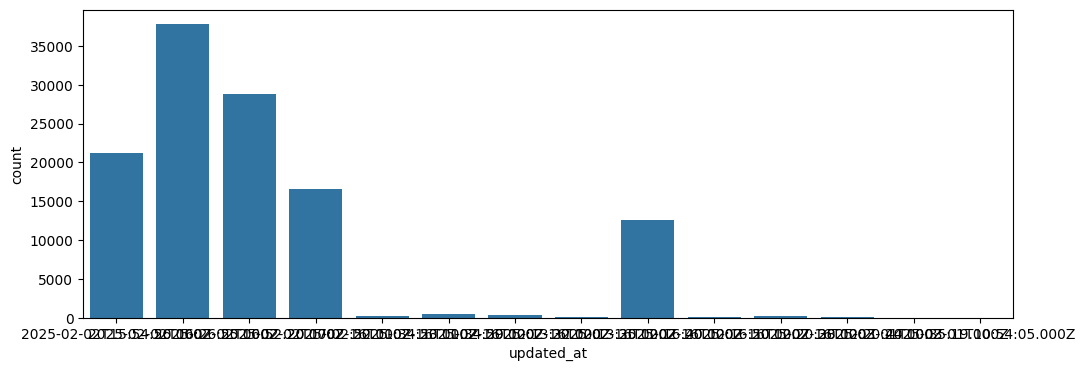

In [14]:
plt.figure(figsize=(12, 4))
sns.countplot(x='updated_at', data=df, order=sorted(df['updated_at'].dropna().unique()))
plt.show()

In [15]:
df['updated_at'] = pd.to_datetime(df['updated_at']).values.astype('datetime64[ms]').astype(int)
# in case any values are missing
df['updated_at'] = df['updated_at'].fillna(0)

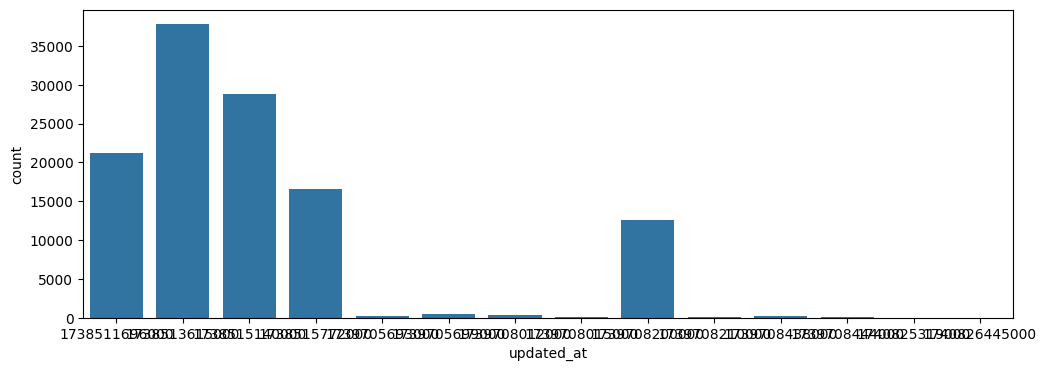

In [16]:
plt.figure(figsize=(12, 4))
sns.countplot(x='updated_at', data=df, order=sorted(df['updated_at'].unique()))
plt.show()

## Property Class
We can map these values to integers for now to help with correlation and switch them back to categorical later

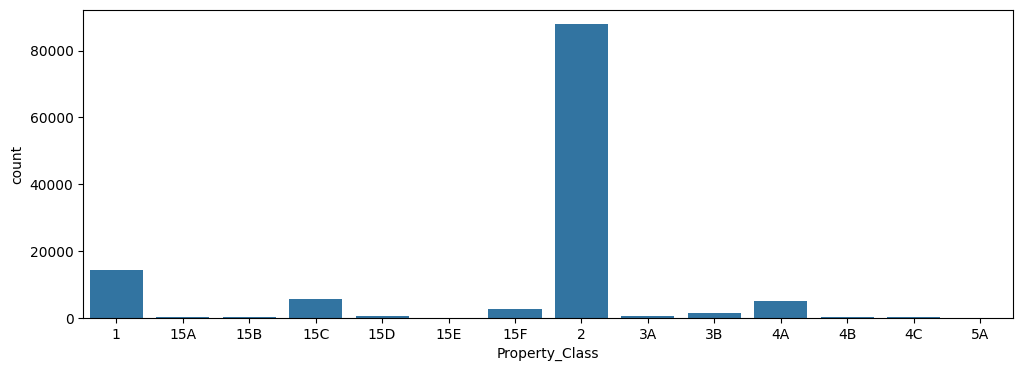

In [17]:
plt.figure(figsize=(12, 4))
sns.countplot(x='Property_Class', data=df, order=sorted(df['Property_Class'].dropna().unique()))
plt.show()

In [18]:
df['Property_Class'] = df['Property_Class'].map({
    '1': 1, '2': 2, '3A': 3, '3B': 4, '4A': 5, '4B': 6, '4C': 7, '5A': 8, '5B': 9, '6A': 10,
    '6B': 11, '6C': 12, '15A': 13, '15B': 14, '15C': 15, '15D': 16, '15E': 17, '15F': 18
})

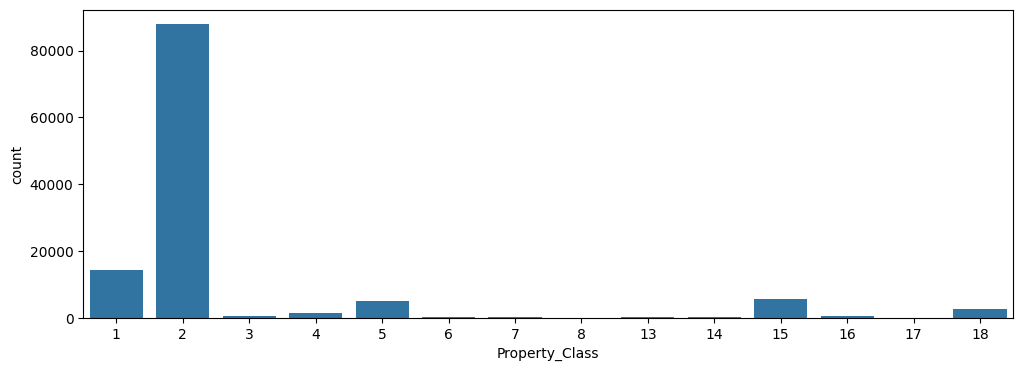

In [19]:
plt.figure(figsize=(12, 4))
sns.countplot(x='Property_Class', data=df, order=sorted(df['Property_Class'].unique()))
plt.show()

And for now we'll limit our anlaysis to residential properties.

In [20]:
df = df[df['Property_Class'] == 2]
len(df)

87876

## Building Class
This data is a measure of quality, there are some inconsistencies that we'll attempt to address by consolidating duplicate keys.

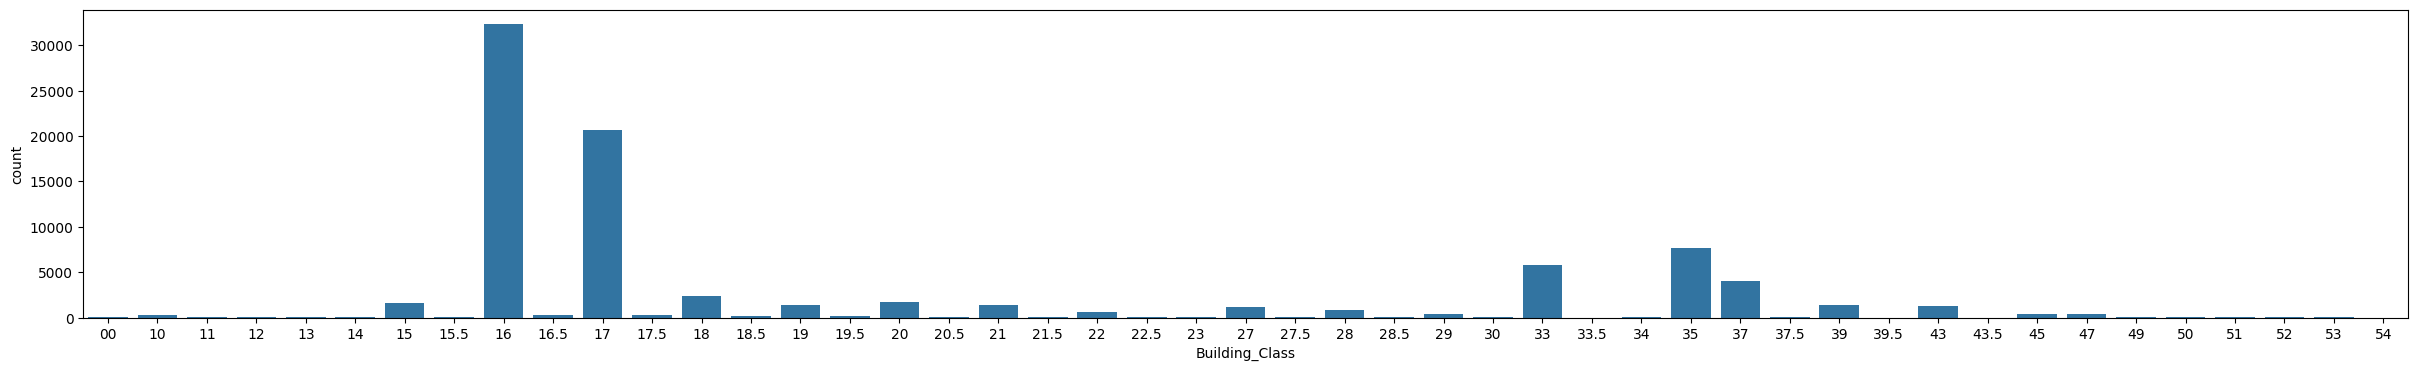

In [21]:
plt.figure(figsize=(30, 4))
sns.countplot(x='Building_Class', data=df, order=sorted(df['Building_Class'].dropna().unique()))
plt.show()

In [22]:
def convert_building_class(value):
    if pd.notna(value):
        if value.isdigit():
            return int(value)
        else:
            try:
                value = value.replace('+', '.5')
                return round(float(value))
            except ValueError:
                return None

In [23]:
df['Building_Class'] = df['Building_Class'].apply(lambda x: convert_building_class(x)).astype(pd.Int64Dtype())

In [24]:
update_mapping = pd.DataFrame({
    'key':[
        26, 27, 28, 29, 30,
        33, 34, 35, 36, 37, 38, 39,
        43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55
    ], 'value':[
        12, 13, 14, 16, 18,
        13, 14, 15, 16, 17, 18, 19,
        13, 14, 15, 16, 17, 18, 19,
        12, 13, 15, 18, 19, 20
    ]
})
df['Building_Class'] = df['Building_Class'].replace(dict(zip(update_mapping['key'], update_mapping['value'])))

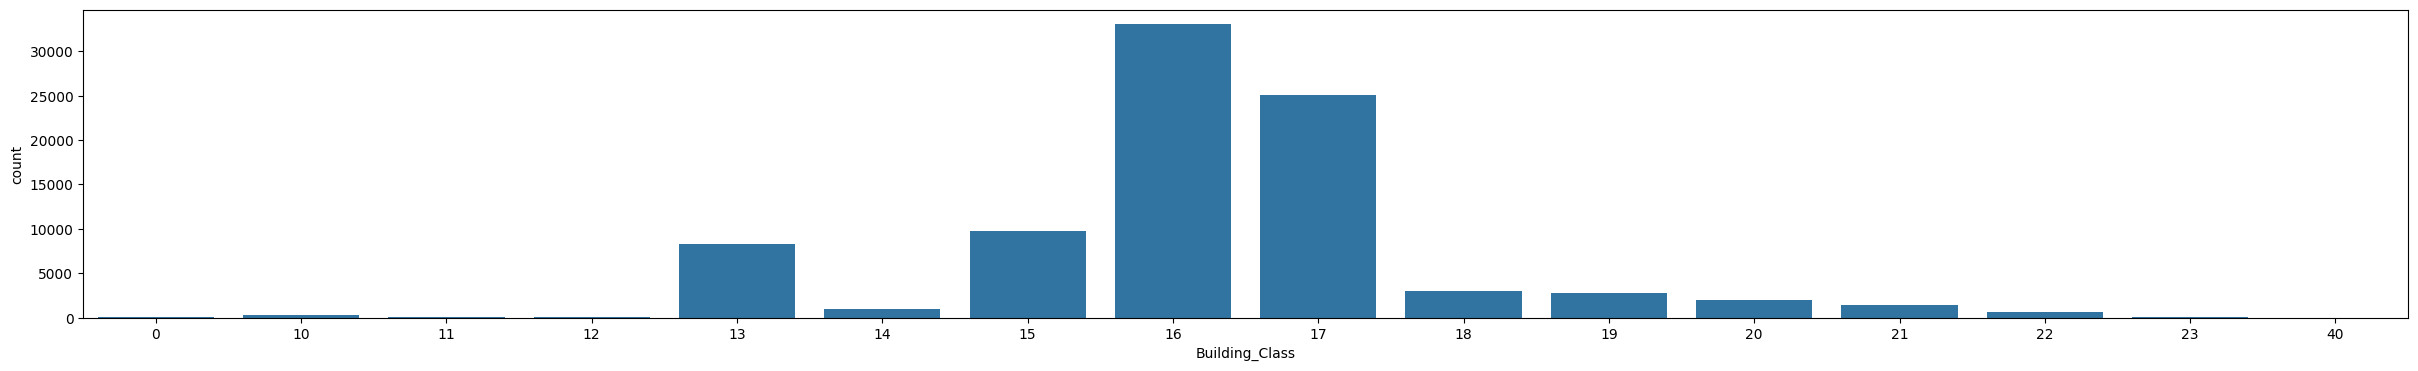

In [25]:
plt.figure(figsize=(30, 4))
sns.countplot(x='Building_Class', data=df, order=sorted(df['Building_Class'].dropna().unique()))
plt.show()

## Sale Date
Here we probably only care about the year and month of sale, so we'll engineer those columns and drop the original sale date.

In [26]:
df['Sale_Date'] = pd.to_datetime(df['Sale_Date'])
df['Sale_Month'] = df['Sale_Date'].dt.month.astype(pd.Int64Dtype())
df['Sale_Year'] = df['Sale_Date'].dt.year.astype(pd.Int64Dtype())
df = df.drop('Sale_Date', axis=1)

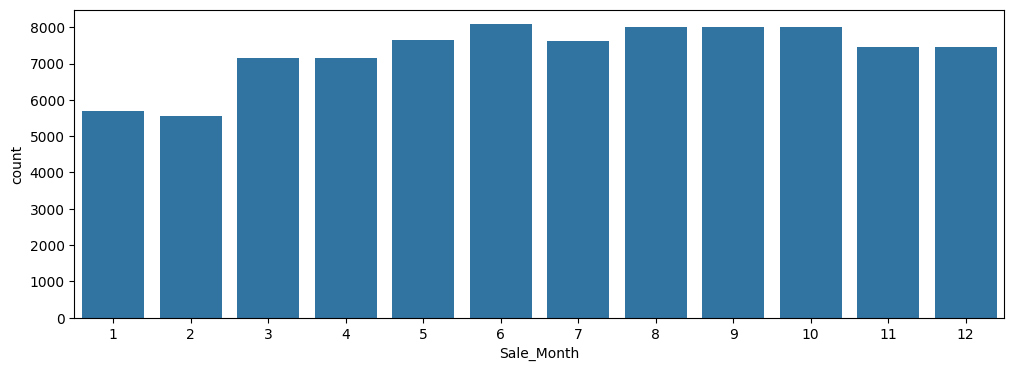

In [27]:
plt.figure(figsize=(12, 4))
sns.countplot(x='Sale_Month', data=df, order=sorted(df['Sale_Month'].dropna().unique()))
plt.show()

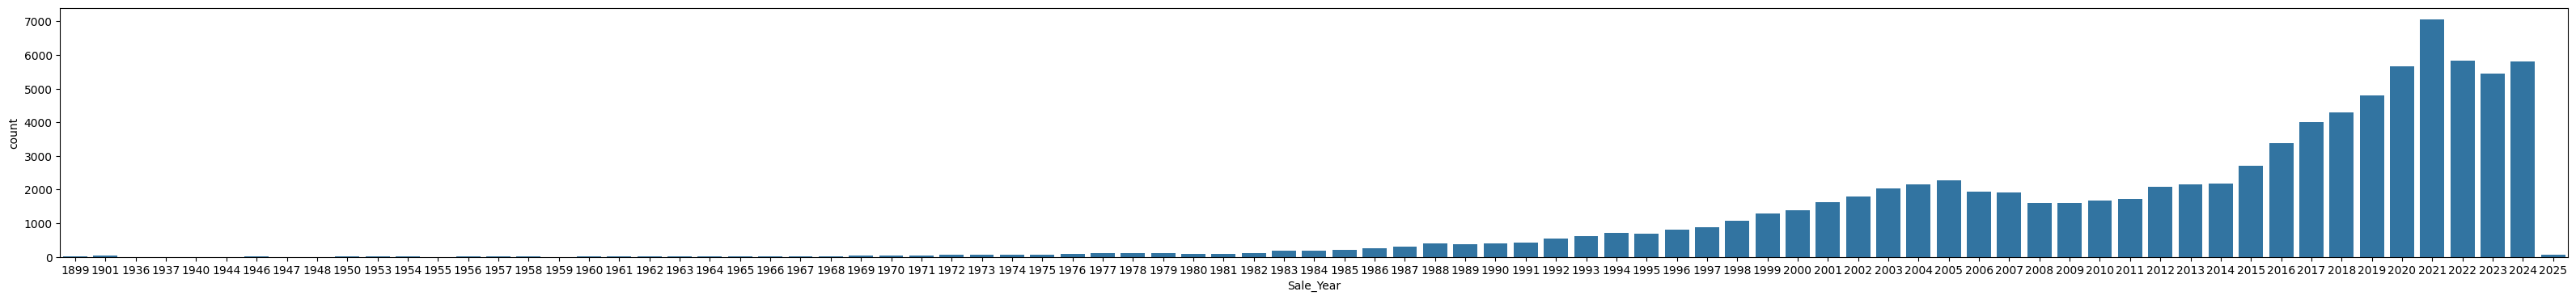

In [28]:
plt.figure(figsize=(40, 4))
sns.countplot(x='Sale_Year', data=df, order=sorted(df['Sale_Year'].dropna().unique()))
plt.show()

## Tax Rate
Here we just need to convert the values to a float data type.

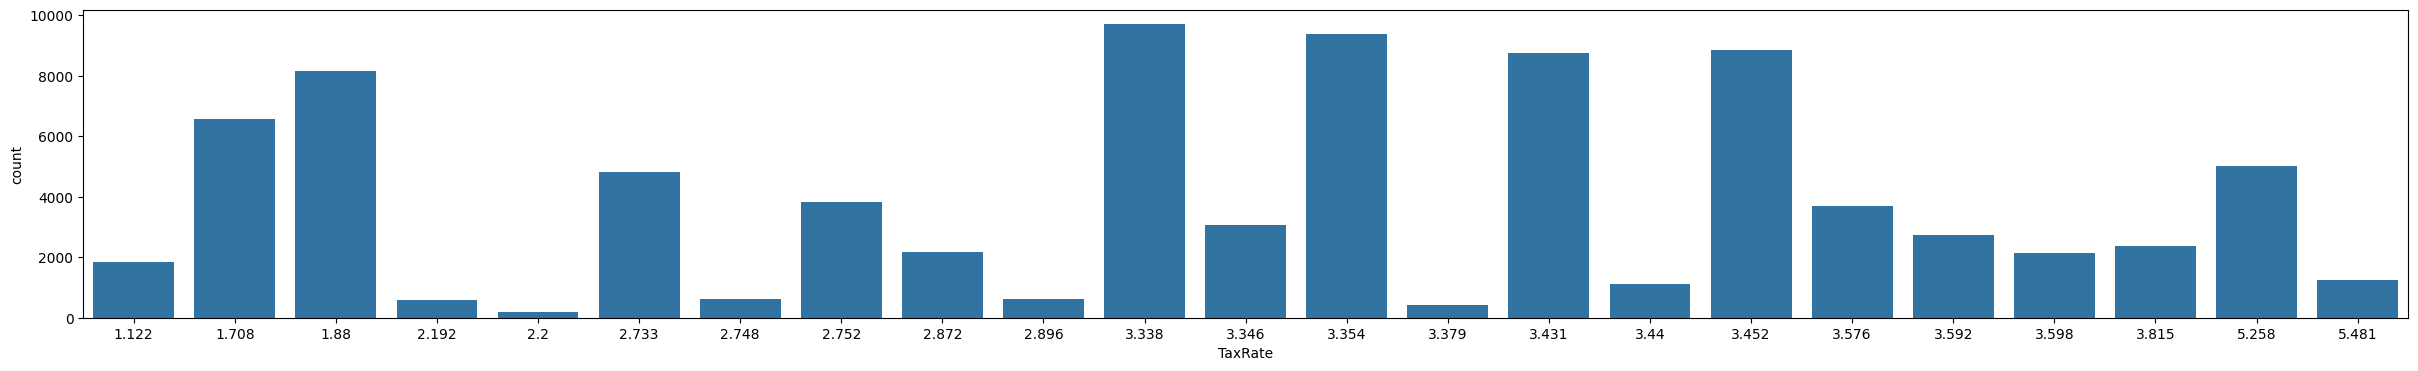

In [29]:
plt.figure(figsize=(30, 4))
sns.countplot(x='TaxRate', data=df, order=sorted(df['TaxRate'].dropna().unique()))
plt.show()

In [30]:
df['TaxRate'] = df['TaxRate'].astype(float)

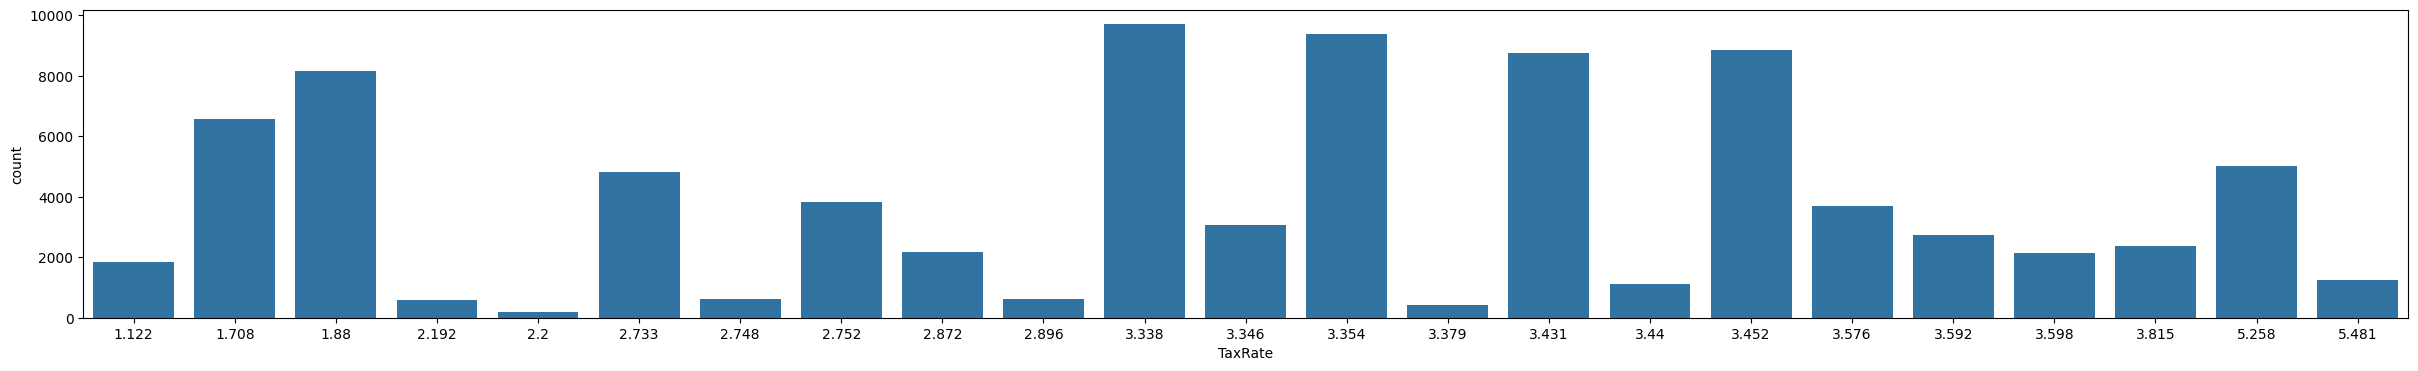

In [31]:
plt.figure(figsize=(30, 4))
sns.countplot(x='TaxRate', data=df, order=sorted(df['TaxRate'].unique()))
plt.show()

## Tax Ratio
Here also we just need to convert the values to a float data type.

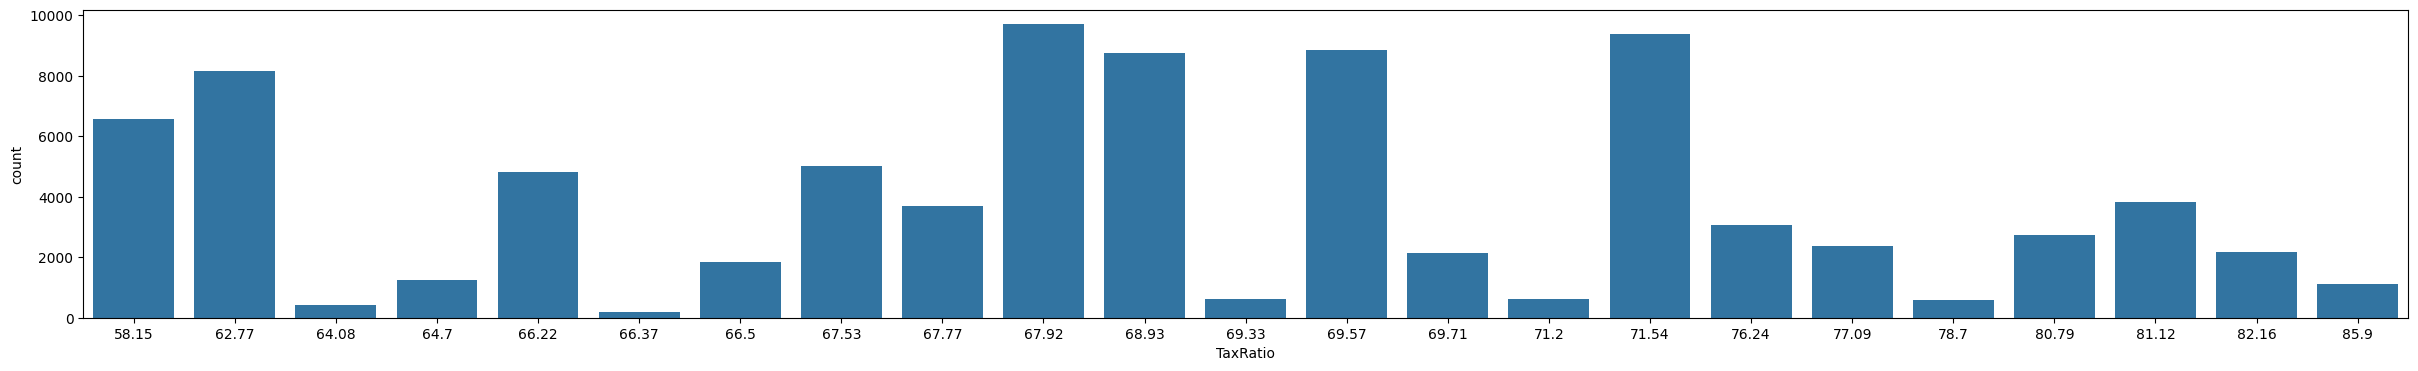

In [32]:
plt.figure(figsize=(30, 4))
sns.countplot(x='TaxRatio', data=df, order=sorted(df['TaxRatio'].dropna().unique()))
plt.show()

In [33]:
df['TaxRatio'] = df['TaxRatio'].astype(float)

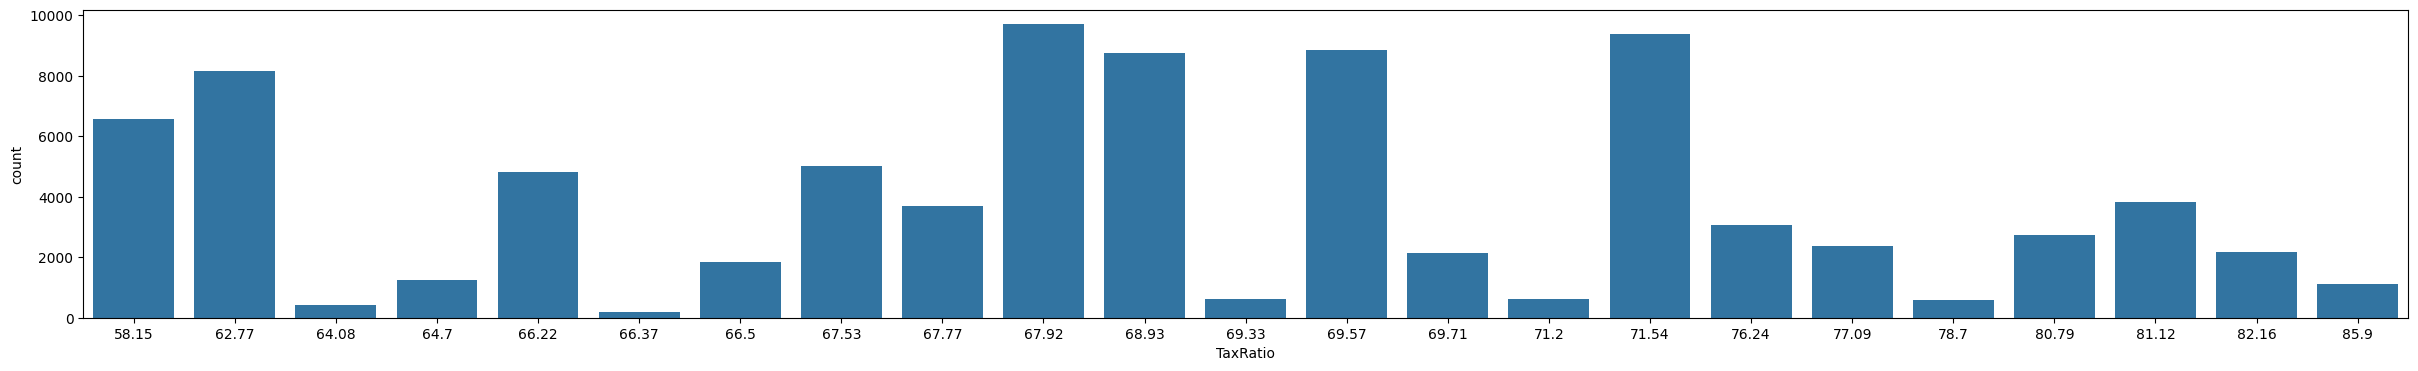

In [34]:
plt.figure(figsize=(30, 4))
sns.countplot(x='TaxRatio', data=df, order=sorted(df['TaxRatio'].unique()))
plt.show()

## Rate Year
Here we just need to convert the values to an int data type.

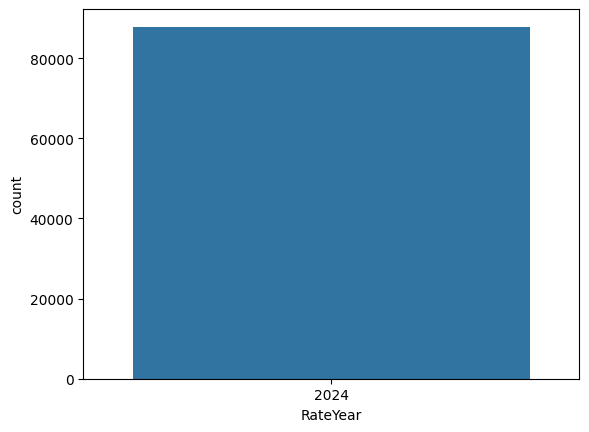

In [35]:
sns.countplot(x='RateYear', data=df, order=sorted(df['RateYear'].dropna().unique()))
plt.show()

In [36]:
df['RateYear'] = df['RateYear'].astype(int)

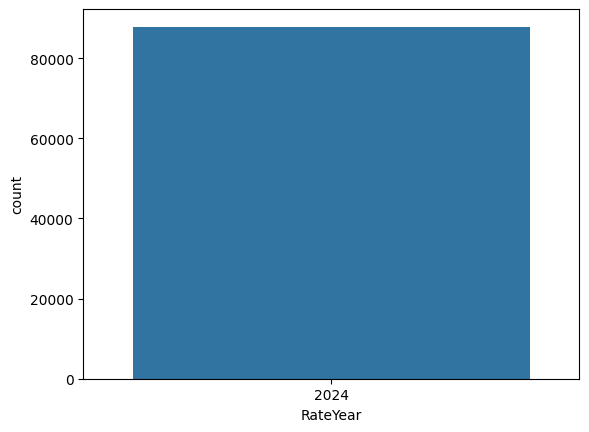

In [37]:
sns.countplot(x='RateYear', data=df, order=sorted(df['RateYear'].unique()))
plt.show()

## Ratio Year
Here also we just need to convert the values to an int data type.

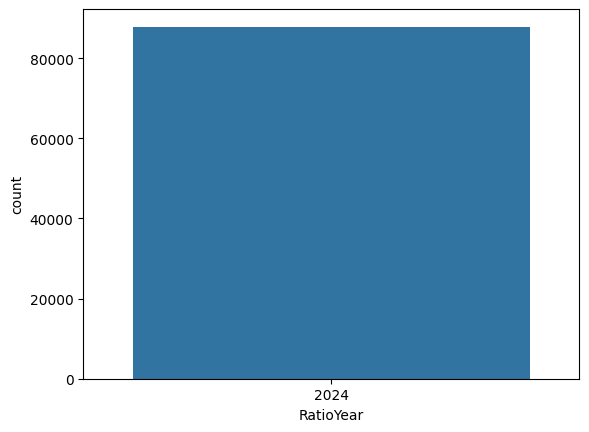

In [38]:
sns.countplot(x='RatioYear', data=df, order=sorted(df['RatioYear'].dropna().unique()))
plt.show()

In [39]:
df['RatioYear'] = df['RatioYear'].astype(int)

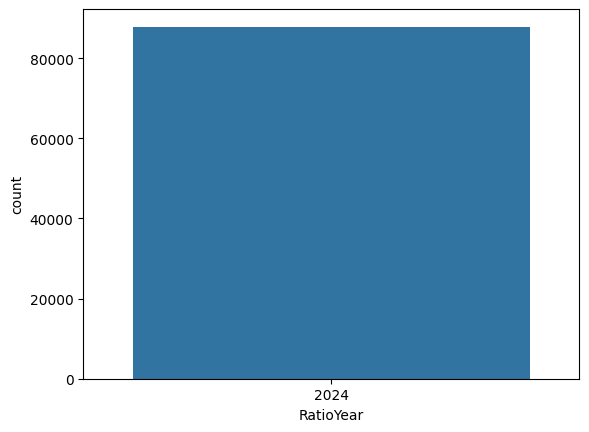

In [40]:
sns.countplot(x='RatioYear', data=df, order=sorted(df['RatioYear'].unique()))
plt.show()

## Bed
And we'll convert the values for bed to a numeric data type.

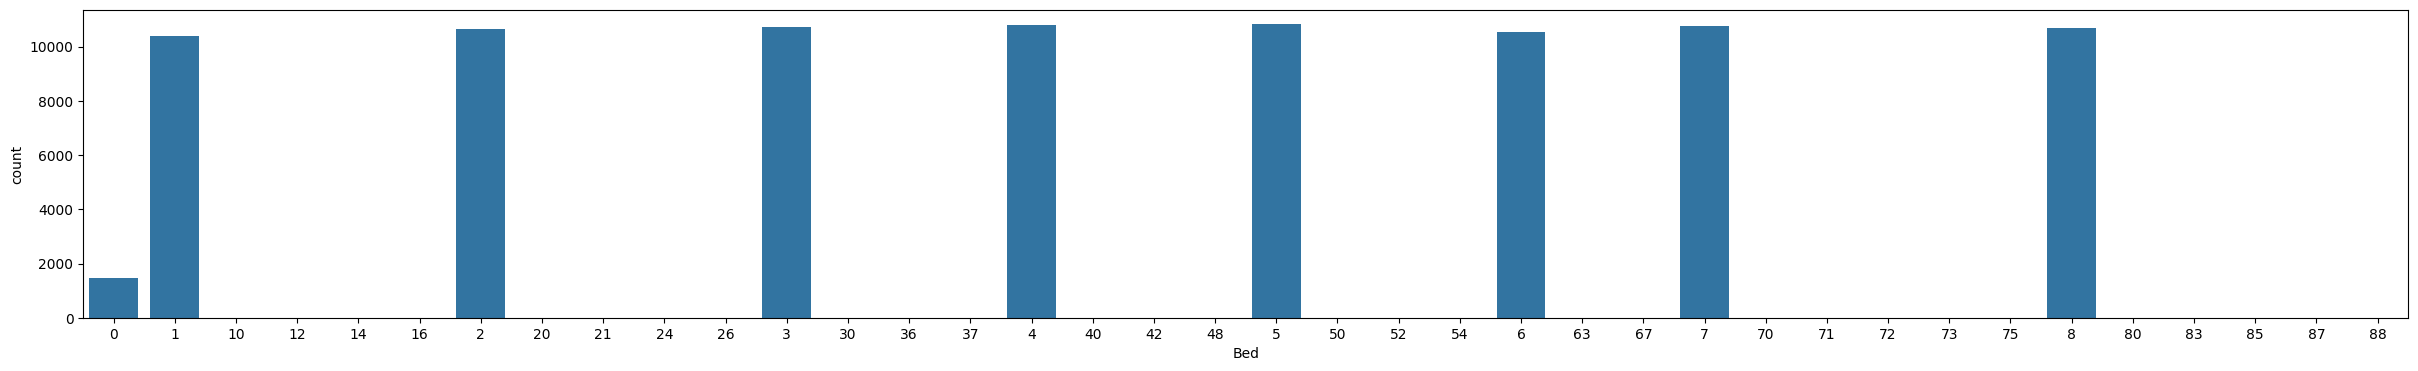

In [41]:
plt.figure(figsize=(30, 4))
sns.countplot(x='Bed', data=df, order=sorted(df['Bed'].dropna().unique()))
plt.show()

In [42]:
df['Bed'] = pd.to_numeric(df['Bed'], errors='coerce').astype(pd.Int64Dtype())

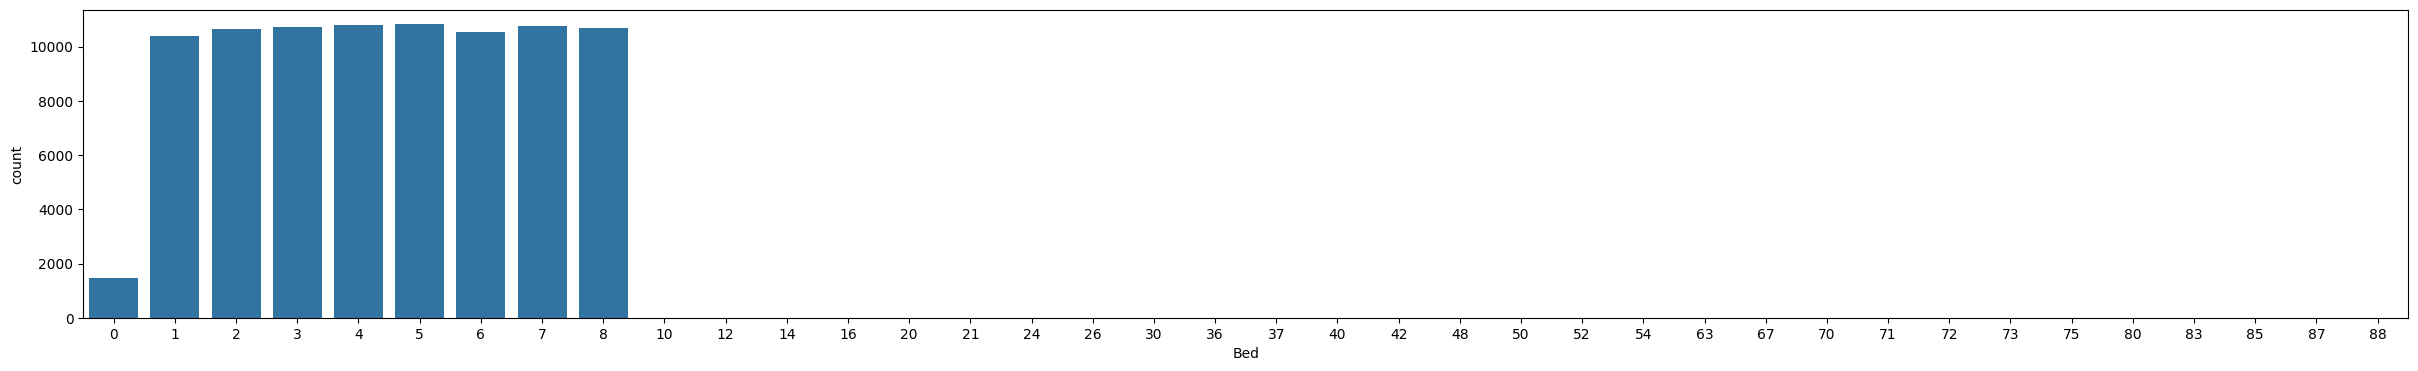

In [43]:
plt.figure(figsize=(30, 4))
sns.countplot(x='Bed', data=df, order=sorted(df['Bed'].dropna().unique()))
plt.show()

## Total Rooms
And we'll also convert the values for total rooms to a numeric data type.

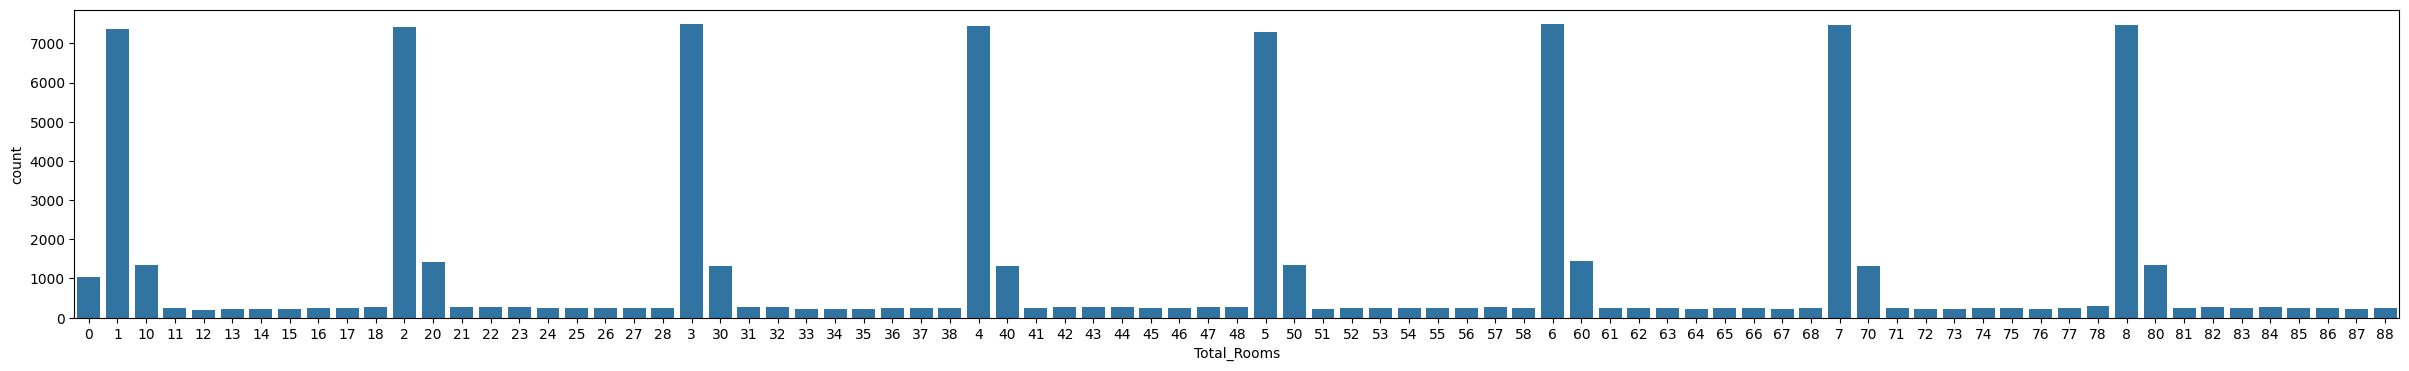

In [44]:
plt.figure(figsize=(30, 4))
sns.countplot(x='Total_Rooms', data=df, order=sorted(df['Total_Rooms'].dropna().unique()))
plt.show()

In [45]:
df['Total_Rooms'] = pd.to_numeric(df['Total_Rooms'], errors='coerce').astype(pd.Int64Dtype())

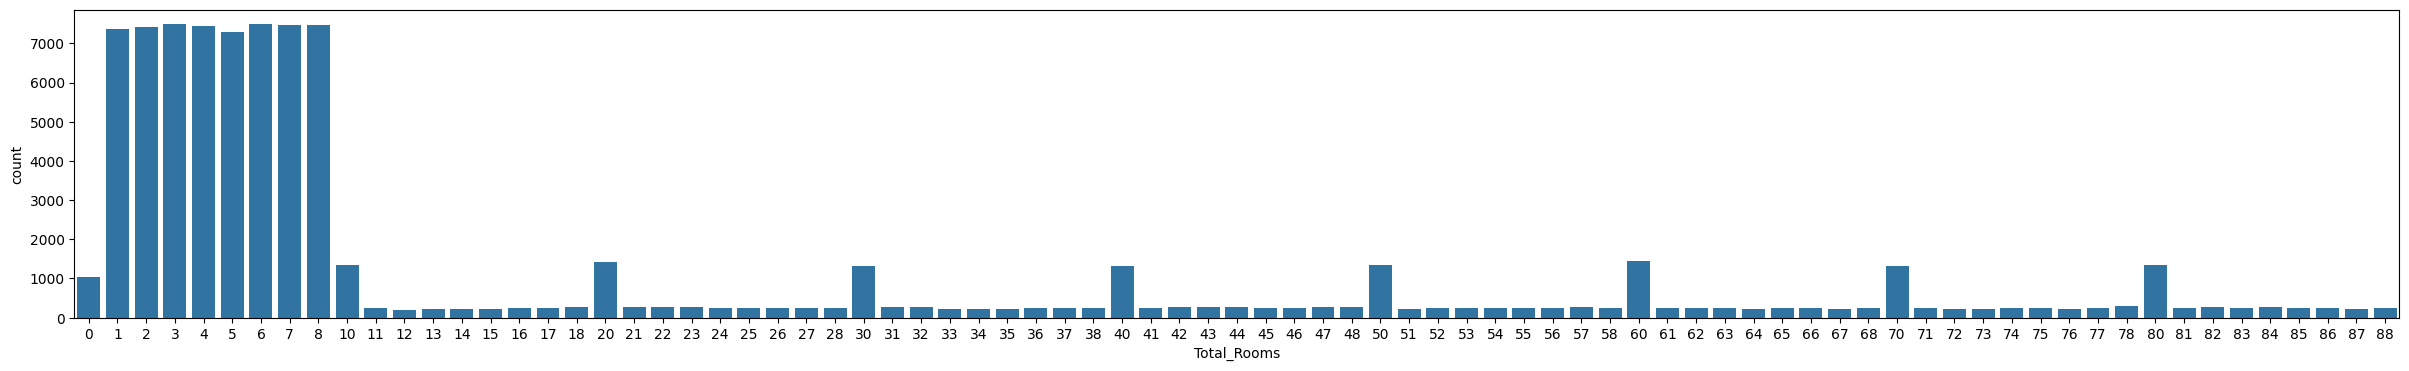

In [46]:
plt.figure(figsize=(30, 4))
sns.countplot(x='Total_Rooms', data=df, order=sorted(df['Total_Rooms'].dropna().unique()))
plt.show()

## Recorded Taxes Year
We need to impute this column to remove any NaN values, averaging by county.

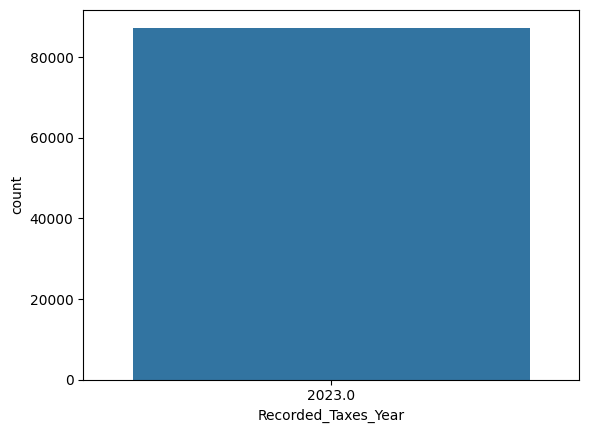

In [47]:
sns.countplot(x='Recorded_Taxes_Year', data=df, order=sorted(df['Recorded_Taxes_Year'].dropna().unique()))
plt.show()

In [48]:
avg_recorded_taxes_year = df.groupby('County')['Recorded_Taxes_Year'].mean()
def fill_recorded_taxes_year(county, taxes_year):
    if (np.isnan(taxes_year)):
        return round(avg_recorded_taxes_year[county])
    else:
        return taxes_year

In [49]:
df['Recorded_Taxes_Year'] = df.apply(lambda x: fill_recorded_taxes_year(x['County'], x['Recorded_Taxes_Year']), axis=1)
df['Recorded_Taxes_Year'] = df['Recorded_Taxes_Year'].astype(int)

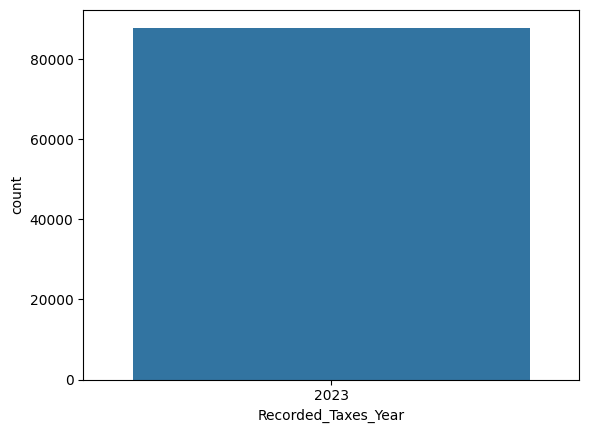

In [50]:
sns.countplot(x='Recorded_Taxes_Year', data=df, order=sorted(df['Recorded_Taxes_Year'].unique()))
plt.show()

## Calculated Taxes Year
We also need to impute this column to remove any NaN values, averaging by county.

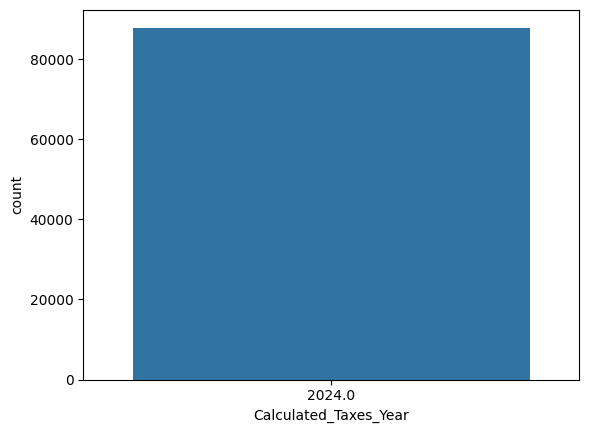

In [51]:
sns.countplot(x='Calculated_Taxes_Year', data=df, order=sorted(df['Calculated_Taxes_Year'].dropna().unique()))
plt.show()

In [52]:
avg_calculated_taxes_year = df.groupby('County')['Calculated_Taxes_Year'].mean()
def fill_calculated_taxes_year(county, taxes_year):
    if (np.isnan(taxes_year)):
        return round(avg_calculated_taxes_year[county])
    else:
        return taxes_year

In [53]:
df['Calculated_Taxes_Year'] = df.apply(lambda x: fill_calculated_taxes_year(x['County'], x['Calculated_Taxes_Year']), axis=1)
df['Calculated_Taxes_Year'] = df['Calculated_Taxes_Year'].astype(int)

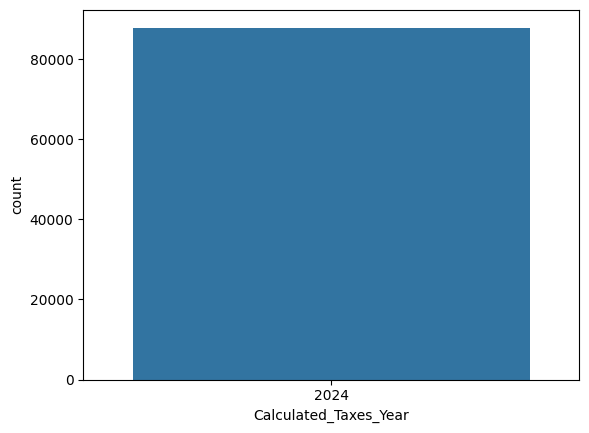

In [54]:
sns.countplot(x='Calculated_Taxes_Year', data=df, order=sorted(df['Calculated_Taxes_Year'].unique()))
plt.show()

## Correlation Chart
Now we can view the correlation metrics for all 36 of our features and our label.

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87876 entries, 364 to 146799
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    79983 non-null  float64
 1   lng                    79983 non-null  float64
 2   Number_Of_Owners       35093 non-null  float64
 3   No_Of_Dwellings        87302 non-null  float64
 4   Corporate_Owned        87876 non-null  bool   
 5   Absentee               87876 non-null  int64  
 6   NU_Code                87876 non-null  int64  
 7   updated_at             87876 non-null  int64  
 8   TotalUnits             87876 non-null  int64  
 9   Acreage                74482 non-null  float64
 10  Sq_Ft                  87876 non-null  int64  
 11  Property_Class         87876 non-null  int64  
 12  Building_Class         87446 non-null  Int64  
 13  Yr_Built               87876 non-null  int64  
 14  TaxRate                87876 non-null  float64
 15  TaxR

<Figure size 640x480 with 0 Axes>

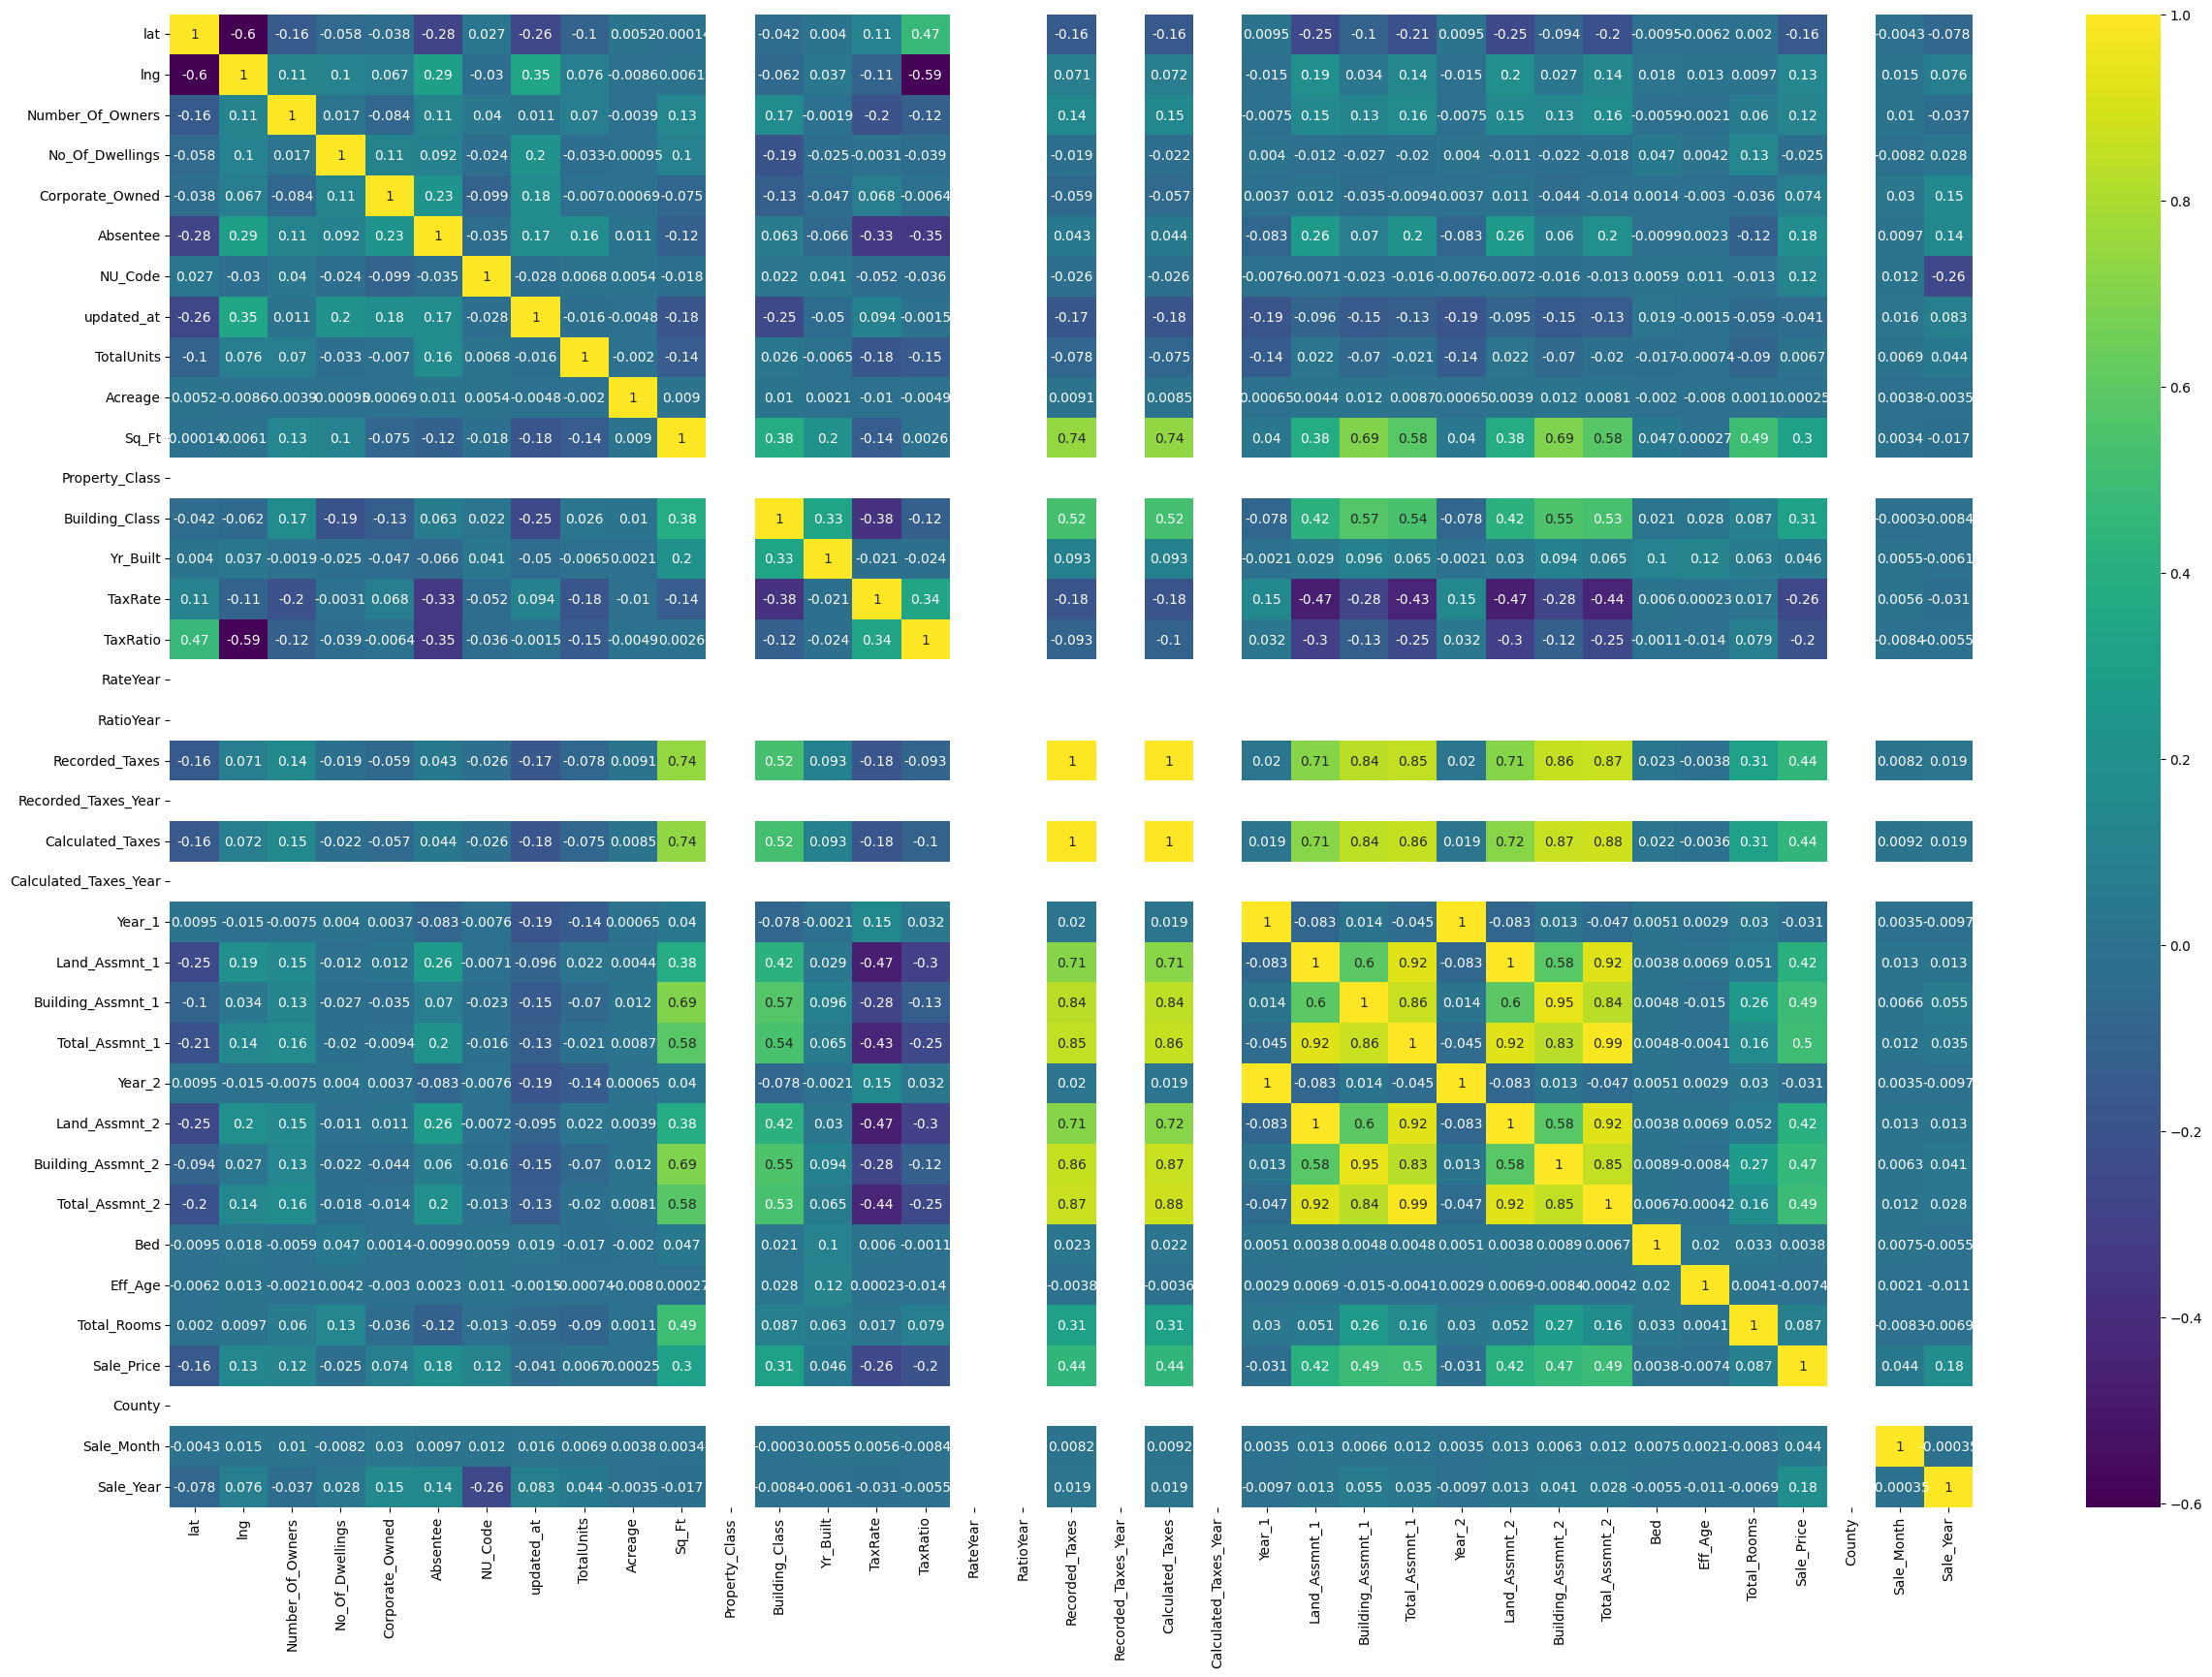

In [56]:
plt.clf()
plt.figure(figsize=(30, 20))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.ylim(37, 0)
plt.show()

# Analyze Missing Data
Review columns and decide how to process missing data 

In [57]:
100 * df.isnull().sum() / len(df)

lat                      8.98
lng                      8.98
Number_Of_Owners        60.07
No_Of_Dwellings          0.65
Corporate_Owned          0.00
Absentee                 0.00
NU_Code                  0.00
updated_at               0.00
TotalUnits               0.00
Acreage                 15.24
Sq_Ft                    0.00
Property_Class           0.00
Building_Class           0.49
Yr_Built                 0.00
TaxRate                  0.00
TaxRatio                 0.00
RateYear                 0.00
RatioYear                0.00
Recorded_Taxes           0.71
Recorded_Taxes_Year      0.00
Calculated_Taxes         0.00
Calculated_Taxes_Year    0.00
Year_1                   0.00
Land_Assmnt_1            0.00
Building_Assmnt_1        0.00
Total_Assmnt_1           0.00
Year_2                   0.00
Land_Assmnt_2            0.00
Building_Assmnt_2        0.00
Total_Assmnt_2           0.00
Bed                      1.09
Eff_Age                  4.91
Total_Rooms              1.09
Sale_Price

## Building and Total Assessments
We need assessment values to impute data for some of the other fields required for our analysis.  And since there are a small number of properties missing assessment values, we will remove those records from the data.  We'll also ignore properties without a geolocation.

In [58]:
df = df.dropna(subset=['Land_Assmnt_1'])
df = df.dropna(subset=['Building_Assmnt_1'])
df = df.dropna(subset=['Total_Assmnt_1'])
df = df.dropna(subset=['Land_Assmnt_2'])
df = df.dropna(subset=['Building_Assmnt_2'])
df = df.dropna(subset=['Total_Assmnt_2'])
df = df.dropna(subset=['lat'])
df = df.dropna(subset=['lng'])
len(df)

79983

## Building Class
Let's take a look at the values and see if there's a strong correlation to any other features.

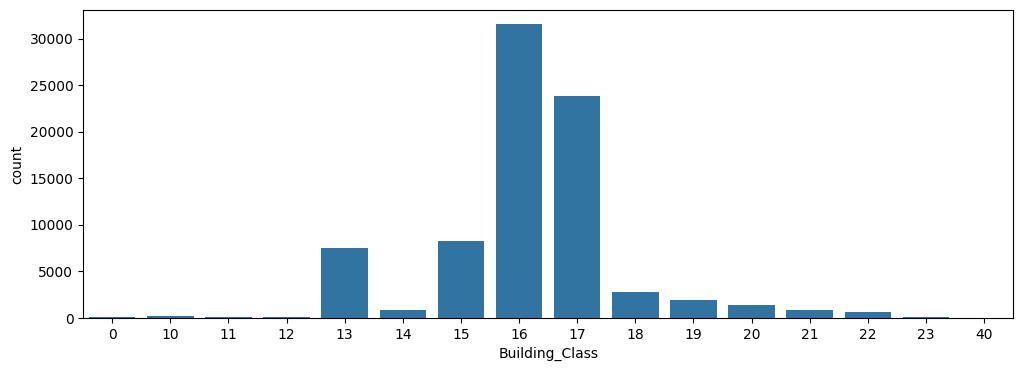

In [59]:
plt.figure(figsize=(12, 4))
sns.countplot(x='Building_Class', data=df, order=sorted(df['Building_Class'].dropna().unique()))
plt.show()

In [60]:
# check the correlation scores for properties
df.corr()['Building_Class'].sort_values()

TaxRate                 -0.37
updated_at              -0.29
No_Of_Dwellings         -0.20
Corporate_Owned         -0.14
TaxRatio                -0.09
lng                     -0.06
lat                     -0.04
Sale_Year               -0.01
Sale_Month               0.00
Acreage                  0.01
Year_2                   0.01
Year_1                   0.01
NU_Code                  0.01
Absentee                 0.02
Bed                      0.03
Eff_Age                  0.03
TotalUnits               0.07
Total_Rooms              0.09
Number_Of_Owners         0.17
Sale_Price               0.32
Yr_Built                 0.35
Sq_Ft                    0.43
Land_Assmnt_1            0.43
Land_Assmnt_2            0.43
Total_Assmnt_2           0.55
Recorded_Taxes           0.55
Calculated_Taxes         0.56
Total_Assmnt_1           0.56
Building_Assmnt_2        0.57
Building_Assmnt_1        0.59
Building_Class           1.00
Property_Class            NaN
RateYear                  NaN
RatioYear 

There appears to be a strong enough correlation between total assessment and building class.  We can impute the missing data based on an average across this feature.

In [61]:
avg_bld_class = df[df['Building_Class'].notna()].groupby('Total_Assmnt_1').mean()['Building_Class']
def fill_building_class(tot_asmt, bld_cls):
    if (pd.isna(bld_cls)):
        valid_indices = avg_bld_class.index[avg_bld_class.index <= tot_asmt]
        if not valid_indices.empty:
          return avg_bld_class[valid_indices.max()]
        valid_indices = avg_bld_class.index[avg_bld_class.index > tot_asmt]
        if not valid_indices.empty:
          return avg_bld_class[valid_indices.min()]
        else:
          return 0
    else:
        return bld_cls

In [62]:
df['Building_Class'] = df.apply(lambda x: fill_building_class(x['Total_Assmnt_1'], x['Building_Class']), axis=1)
df['Building_Class'] = df['Building_Class'].astype(pd.Float64Dtype()).round().astype(pd.Int64Dtype())

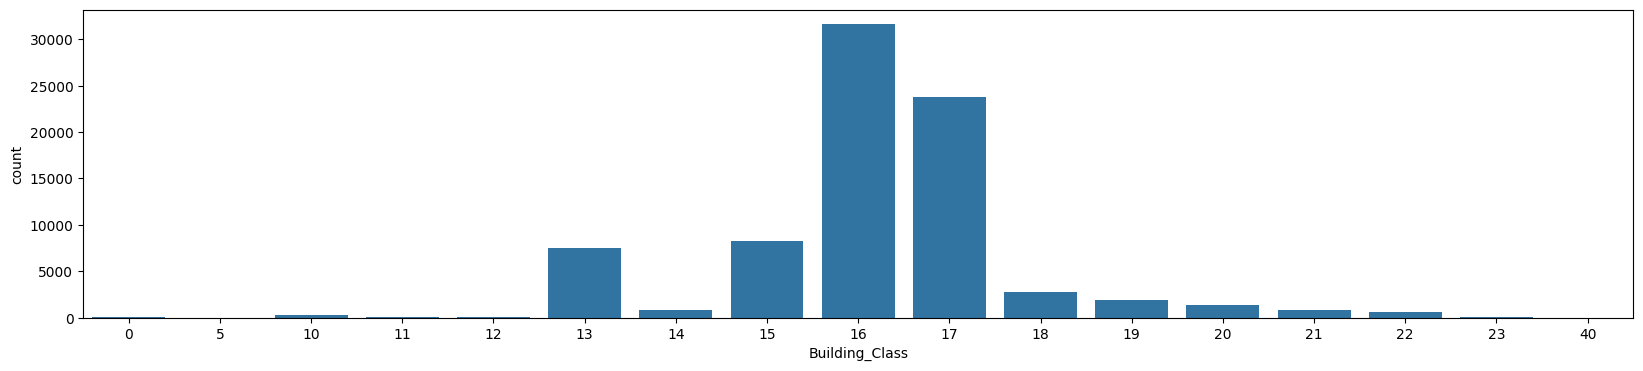

In [63]:
plt.figure(figsize=(20, 4))
sns.countplot(x='Building_Class', data=df, order=sorted(df['Building_Class'].unique()))
plt.show()

## Square Feet
Let's take a look at the values and see if there's a strong correlation to any other features.

In [64]:
# check the correlation scores for properties
df.corr()['Sq_Ft'].sort_values()

TaxRate                 -0.23
updated_at              -0.19
TotalUnits              -0.09
Corporate_Owned         -0.08
Absentee                -0.07
TaxRatio                -0.06
Sale_Year               -0.02
Year_2                  -0.02
Year_1                  -0.02
NU_Code                 -0.01
lat                     -0.00
Eff_Age                  0.00
Sale_Month               0.00
lng                      0.01
Acreage                  0.02
Bed                      0.05
No_Of_Dwellings          0.11
Number_Of_Owners         0.14
Yr_Built                 0.21
Sale_Price               0.33
Land_Assmnt_1            0.41
Land_Assmnt_2            0.41
Building_Class           0.43
Total_Rooms              0.49
Total_Assmnt_2           0.59
Total_Assmnt_1           0.60
Building_Assmnt_2        0.69
Building_Assmnt_1        0.70
Calculated_Taxes         0.73
Recorded_Taxes           0.74
Sq_Ft                    1.00
Property_Class            NaN
RateYear                  NaN
RatioYear 

There appears to be a strong enough correlation between building assessment and square feet.  We can impute the missing data based on an average across this feature.

In [65]:
avg_feet = df[df['Sq_Ft'].notna()].groupby('Building_Assmnt_1').mean()['Sq_Ft']
def fill_square_feet(bld_asmt, sq_ft):
    if (pd.isna(sq_ft)):
        valid_indices = avg_feet.index[avg_feet.index <= bld_asmt]
        if not valid_indices.empty:
          return avg_feet[valid_indices.max()]
        valid_indices = avg_feet.index[avg_feet.index > bld_asmt]
        if not valid_indices.empty:
          return avg_feet[valid_indices.min()]
        else:
          return 0
    else:
        return sq_ft

In [66]:
df['Sq_Ft'] = df.apply(lambda x: fill_square_feet(x['Building_Assmnt_1'], x['Sq_Ft']), axis=1)

## Total Rooms
Let's take a look at the values and see if there's a strong correlation to any other features.

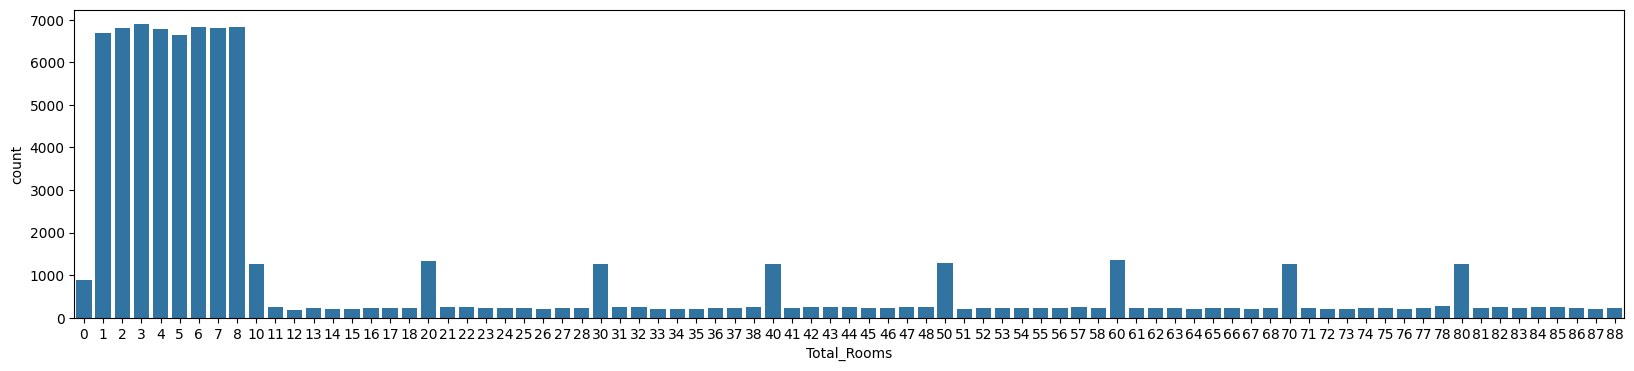

In [67]:
plt.figure(figsize=(20, 4))
sns.countplot(x='Total_Rooms', data=df, order=sorted(df['Total_Rooms'].dropna().unique()))
plt.show()

In [68]:
# check the correlation scores for properties
df.corr()['Total_Rooms'].sort_values()

Absentee                -0.09
TotalUnits              -0.06
updated_at              -0.06
Corporate_Owned         -0.03
TaxRate                 -0.02
Year_2                  -0.02
Year_1                  -0.02
NU_Code                 -0.01
Sale_Month              -0.01
Sale_Year               -0.01
lat                      0.00
Eff_Age                  0.01
Acreage                  0.01
lng                      0.01
Bed                      0.03
TaxRatio                 0.05
Land_Assmnt_1            0.06
Land_Assmnt_2            0.06
Yr_Built                 0.06
Number_Of_Owners         0.06
Sale_Price               0.09
Building_Class           0.09
No_Of_Dwellings          0.14
Total_Assmnt_1           0.16
Total_Assmnt_2           0.17
Building_Assmnt_1        0.25
Building_Assmnt_2        0.26
Calculated_Taxes         0.30
Recorded_Taxes           0.30
Sq_Ft                    0.49
Total_Rooms              1.00
Property_Class            NaN
RateYear                  NaN
RatioYear 

There appears to be a reasonable correlation between square feet and total rooms.  We can impute the missing data based on an average across this feature.

In [69]:
avg_rooms = df[df['Total_Rooms'].notna()].groupby('Sq_Ft').mean()['Total_Rooms']
def fill_total_rooms(sq_ft, tot_rooms):
    if (pd.isna(tot_rooms)):
        valid_indices = avg_rooms.index[avg_rooms.index <= sq_ft]
        if not valid_indices.empty:
          return avg_rooms[valid_indices.max()]
        valid_indices = avg_rooms.index[avg_rooms.index > sq_ft]
        if not valid_indices.empty:
          return avg_rooms[valid_indices.min()]
        else:
          return 0
    else:
        return tot_rooms

In [70]:
df['Total_Rooms'] = df.apply(lambda x: fill_total_rooms(x['Sq_Ft'], x['Total_Rooms']), axis=1)
df['Total_Rooms'] = df['Total_Rooms'].astype(pd.Float64Dtype()).round().astype(pd.Int64Dtype())

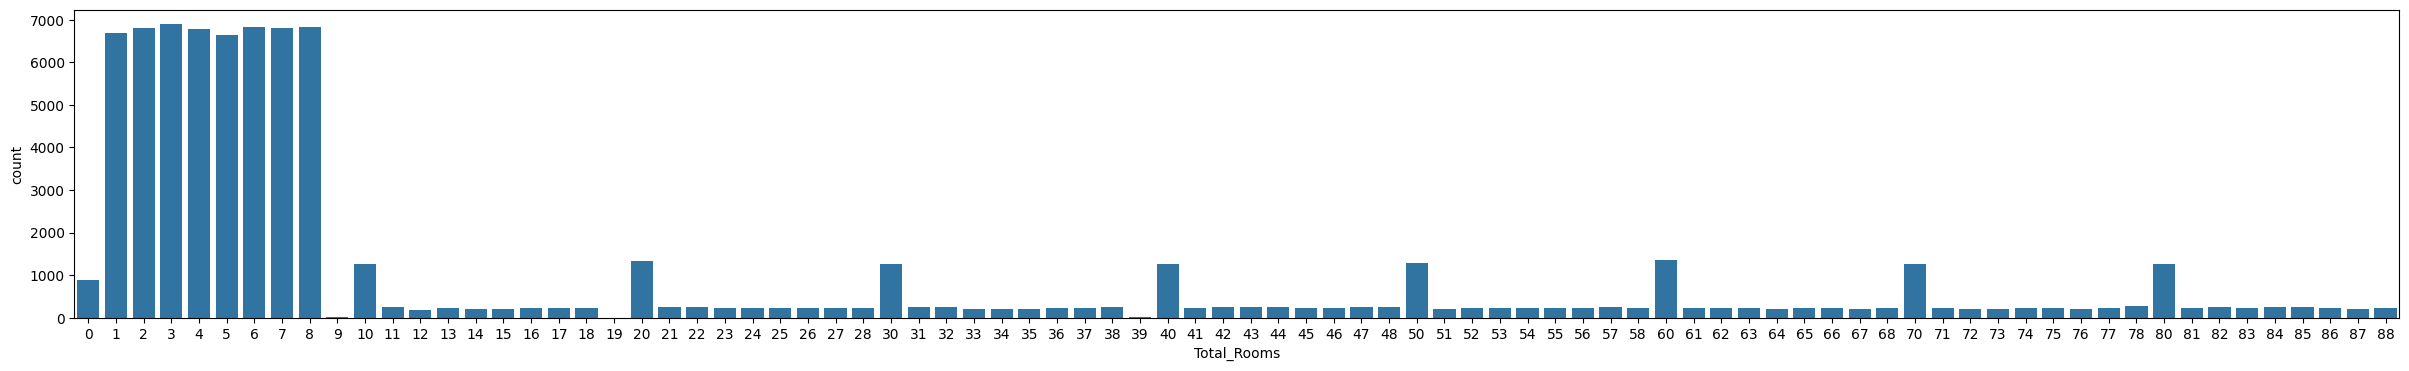

In [71]:
plt.figure(figsize=(30, 4))
sns.countplot(x='Total_Rooms', data=df, order=sorted(df['Total_Rooms'].unique()))
plt.show()

## No of Dwellings
Let's take a look at the values and see if there's a strong correlation to any other features.

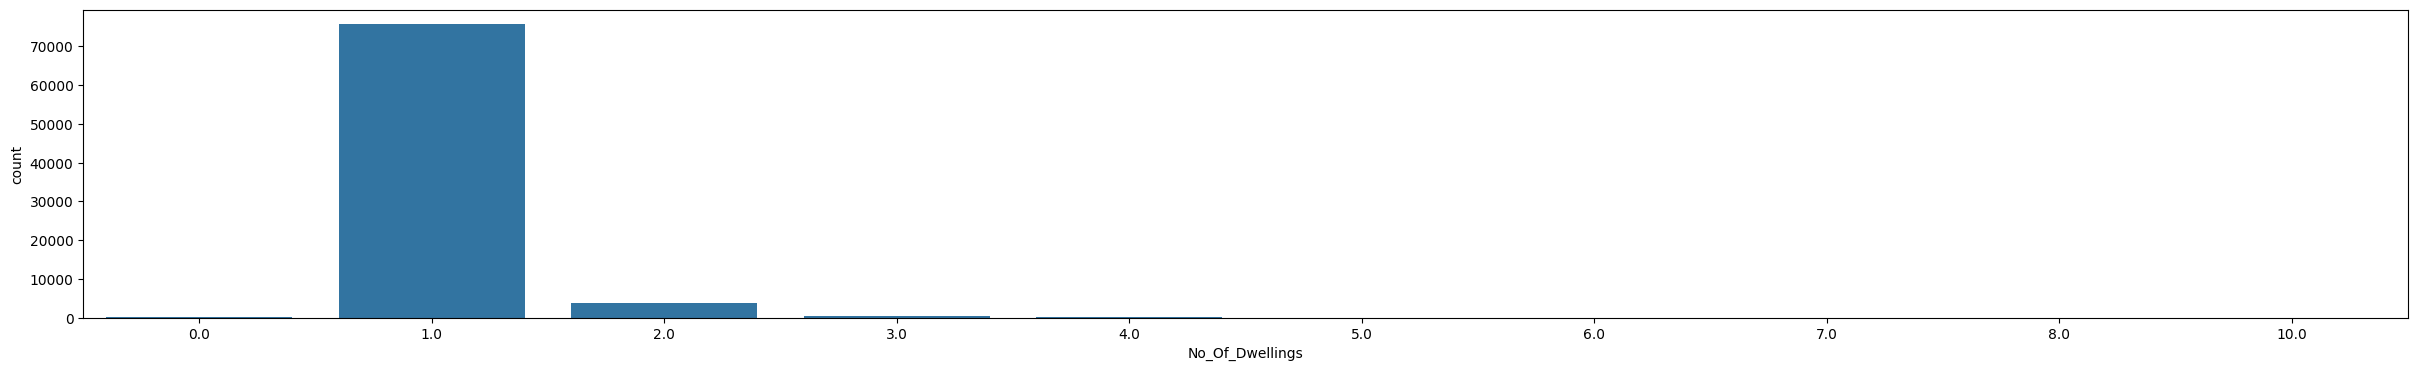

In [72]:
plt.figure(figsize=(30, 4))
sns.countplot(x='No_Of_Dwellings', data=df, order=sorted(df['No_Of_Dwellings'].dropna().unique()))
plt.show()

In [73]:
# check the correlation scores for properties
df.corr()['No_Of_Dwellings'].sort_values()

Building_Class          -0.20
lat                     -0.06
Year_2                  -0.04
Year_1                  -0.04
TaxRatio                -0.03
NU_Code                 -0.03
Yr_Built                -0.03
Sale_Price              -0.03
Building_Assmnt_1       -0.03
Total_Assmnt_1          -0.02
Building_Assmnt_2       -0.02
Calculated_Taxes        -0.02
Total_Assmnt_2          -0.02
TotalUnits              -0.02
Recorded_Taxes          -0.02
Land_Assmnt_1           -0.02
Land_Assmnt_2           -0.02
Sale_Month              -0.01
Acreage                 -0.00
Eff_Age                  0.00
TaxRate                  0.01
Number_Of_Owners         0.01
Sale_Year                0.03
Bed                      0.05
Absentee                 0.10
lng                      0.10
Sq_Ft                    0.11
Corporate_Owned          0.12
Total_Rooms              0.14
updated_at               0.22
No_Of_Dwellings          1.00
Property_Class            NaN
RateYear                  NaN
RatioYear 

There appear to be strong enough correlations between county, building class, square feet and number of dwellings.  We can impute the missing data based on an average across these features.

In [74]:
avg_dwellings = df[df['No_Of_Dwellings'].notna()].groupby(['County', 'Building_Class',
                                                           'Sq_Ft']).agg({'No_Of_Dwellings': 'mean'}).reset_index()
avg_dwellings_county = df[df['No_Of_Dwellings'].notna()].groupby(['County', 'Sq_Ft']).agg({'No_Of_Dwellings': 'mean'}).reset_index()
def fill_no_of_dwellings(county, bld_cls, sq_ft, no_dwell):
    if np.isnan(no_dwell):
        result = 0
        segment = avg_dwellings[(avg_dwellings['County'] == county) &
                                (avg_dwellings['Building_Class'] == bld_cls)]
        if segment.empty:
            segment = avg_dwellings_county[avg_dwellings_county['County'] == county]        
        if not segment.empty:
            filtered = segment[segment['Sq_Ft'] <= sq_ft]
            if not filtered.empty:
                result = filtered.loc[filtered.idxmax()['Sq_Ft']]['No_Of_Dwellings']
            else:
                filtered = segment[segment['Sq_Ft'] > sq_ft]
                if not filtered.empty:
                    result = filtered.loc[filtered.idxmin()['Sq_Ft']]['No_Of_Dwellings']
        return round(result)
    else:
        return no_dwell

In [75]:
df['No_Of_Dwellings'] = df.apply(lambda x: fill_no_of_dwellings(x['County'], x['Building_Class'],
                                                                x['Sq_Ft'], x['No_Of_Dwellings']), axis=1)
df['No_Of_Dwellings'] = df['No_Of_Dwellings'].astype(int)

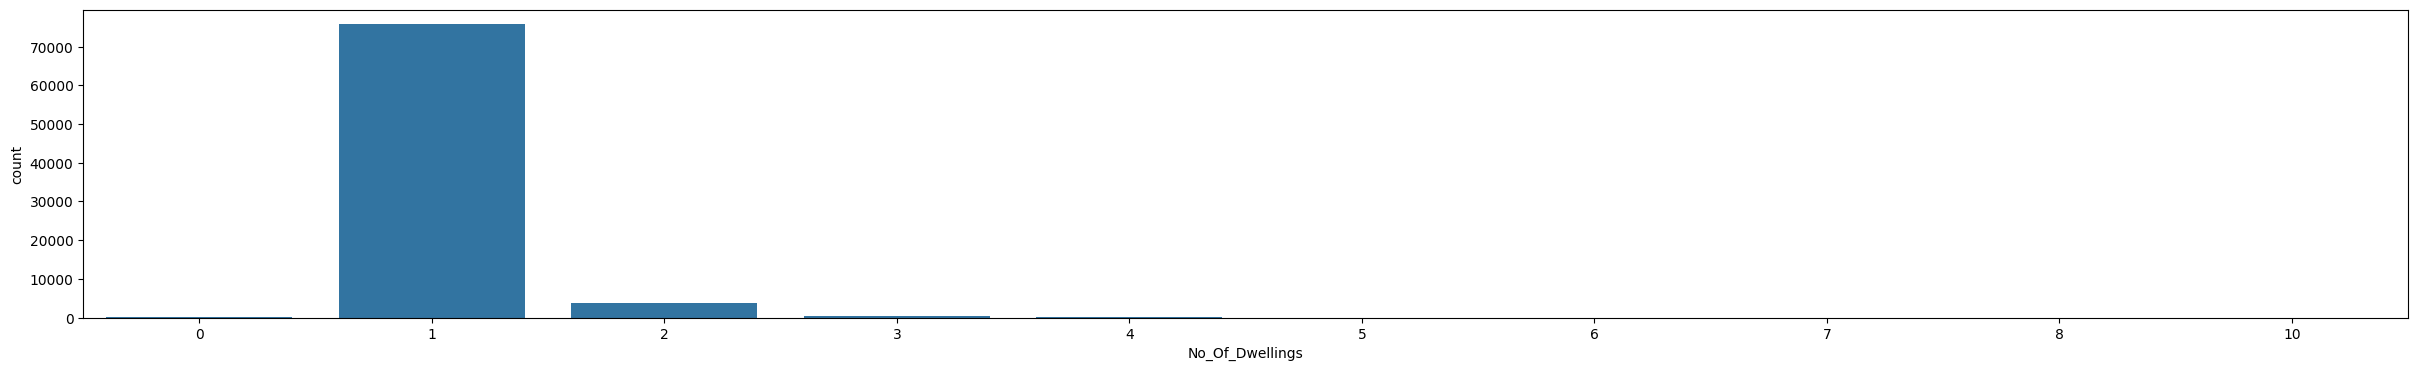

In [76]:
plt.figure(figsize=(30, 4))
sns.countplot(x='No_Of_Dwellings', data=df, order=sorted(df['No_Of_Dwellings'].unique()))
plt.show()

## Bed Rooms
Let's take a look at the values and see if there's a strong correlation to any other features.

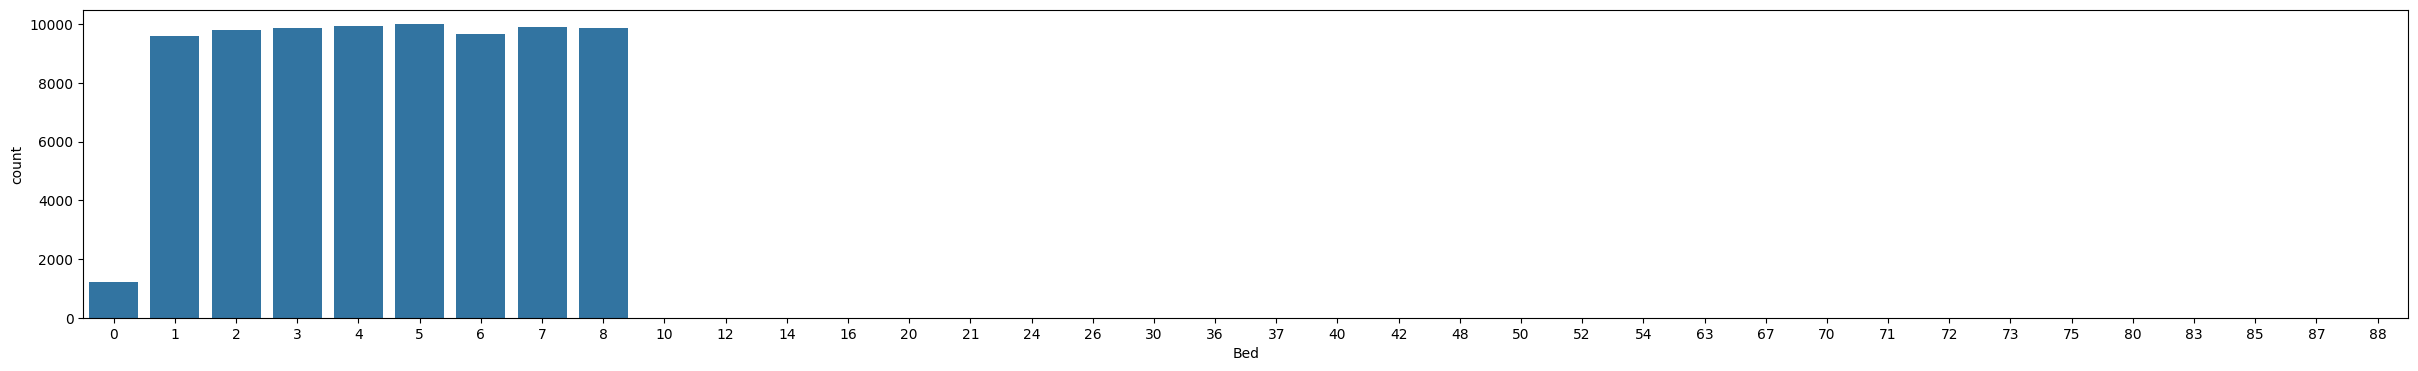

In [77]:
plt.figure(figsize=(30, 4))
sns.countplot(x='Bed', data=df, order=sorted(df['Bed'].dropna().unique()))
plt.show()

In [78]:
# then check the correlation scores for properties
df.corr()['Bed'].sort_values()

TotalUnits              -0.02
lat                     -0.01
Absentee                -0.01
Number_Of_Owners        -0.01
Sale_Year               -0.00
Year_1                  -0.00
Year_2                  -0.00
TaxRatio                -0.00
Corporate_Owned          0.00
TaxRate                  0.00
Acreage                  0.00
NU_Code                  0.01
Land_Assmnt_2            0.01
Land_Assmnt_1            0.01
Sale_Month               0.01
Sale_Price               0.01
Total_Assmnt_1           0.01
Building_Assmnt_1        0.01
Total_Assmnt_2           0.01
Building_Assmnt_2        0.01
lng                      0.02
Eff_Age                  0.02
updated_at               0.02
Calculated_Taxes         0.02
Recorded_Taxes           0.03
Total_Rooms              0.03
Building_Class           0.04
No_Of_Dwellings          0.05
Sq_Ft                    0.05
Yr_Built                 0.10
Bed                      1.00
Property_Class            NaN
RateYear                  NaN
RatioYear 

There's not a great indicator for number of bedrooms across all properties, and it looks like we're missing a lot of data in this field.  If we can't get better data we'll have to drop the column.

In [79]:
df = df.drop('Bed', axis=1)

## Number of Owners
A large amount of data in this column is missing, let's take a look at the values and see if there's a strong correlation to any other features.

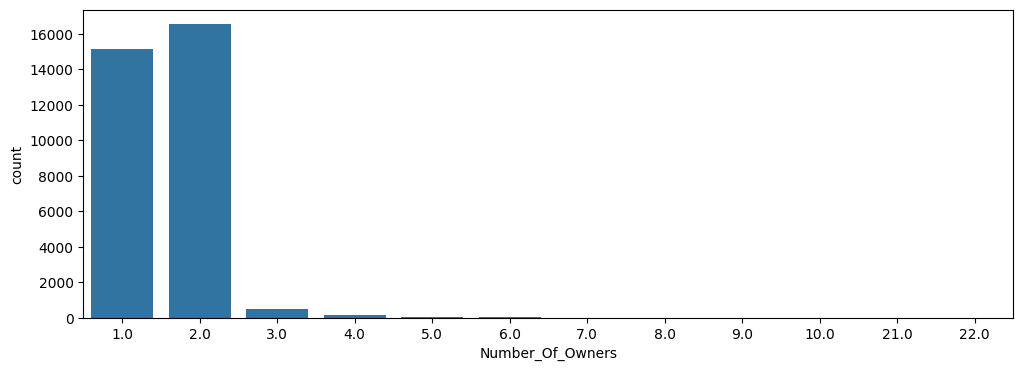

In [80]:
plt.figure(figsize=(12, 4))
sns.countplot(x='Number_Of_Owners', data=df, order=sorted(df['Number_Of_Owners'].dropna().unique()))
plt.show()

In [81]:
df.corr()['Number_Of_Owners'].sort_values()

TaxRate                 -0.20
lat                     -0.16
TaxRatio                -0.11
Corporate_Owned         -0.08
Sale_Year               -0.04
Yr_Built                -0.00
Acreage                 -0.00
Eff_Age                 -0.00
Year_2                   0.00
Year_1                   0.00
Sale_Month               0.01
No_Of_Dwellings          0.01
updated_at               0.01
NU_Code                  0.03
Total_Rooms              0.06
TotalUnits               0.06
Absentee                 0.10
lng                      0.11
Sale_Price               0.12
Building_Assmnt_1        0.13
Building_Assmnt_2        0.14
Sq_Ft                    0.14
Recorded_Taxes           0.15
Land_Assmnt_1            0.15
Calculated_Taxes         0.15
Land_Assmnt_2            0.15
Total_Assmnt_1           0.16
Total_Assmnt_2           0.16
Building_Class           0.17
Number_Of_Owners         1.00
Property_Class            NaN
RateYear                  NaN
RatioYear                 NaN
Recorded_T

There's also not a great indicator for number of owners across all properties, and it looks like we're missing a lot of data in this field too.  If we can't get better data we'll have to drop the column.

In [82]:
df = df.drop('Number_Of_Owners', axis=1)

## Year Built
A large amount of data in this column is missing, let's take a look at the values and see if there's a strong correlation to any other features.

In [83]:
df['Yr_Built'].value_counts()

Yr_Built
1900    3069
1950    2821
1986    2441
1960    2293
1988    1954
        ... 
1854       1
1864       1
1858       1
1871       1
1899       1
Name: count, Length: 210, dtype: int64

In [84]:
df.corr()['Yr_Built'].sort_values()

Absentee                -0.08
updated_at              -0.05
Corporate_Owned         -0.05
No_Of_Dwellings         -0.03
TotalUnits              -0.02
TaxRatio                -0.02
TaxRate                 -0.01
Sale_Year               -0.01
Year_2                  -0.00
Year_1                  -0.00
Acreage                  0.00
lat                      0.00
Sale_Month               0.00
Land_Assmnt_2            0.03
Land_Assmnt_1            0.03
lng                      0.04
NU_Code                  0.04
Sale_Price               0.04
Total_Rooms              0.06
Total_Assmnt_2           0.06
Total_Assmnt_1           0.07
Calculated_Taxes         0.09
Recorded_Taxes           0.09
Building_Assmnt_2        0.10
Building_Assmnt_1        0.10
Eff_Age                  0.12
Sq_Ft                    0.21
Building_Class           0.29
Yr_Built                 1.00
Property_Class            NaN
RateYear                  NaN
RatioYear                 NaN
Recorded_Taxes_Year       NaN
Calculated

There appear to be decent correlations between building class, tax rate, square feet and year built.  We can impute the missing data based on an average across these features.

In [85]:
avg_year = df[df['Yr_Built'].notna()].groupby(['Building_Class', 'TaxRate',
                                               'Sq_Ft']).agg({'Yr_Built': 'mean'}).reset_index()
avg_year_class = df[df['Yr_Built'].notna()].groupby(['Building_Class', 'Sq_Ft']).agg({'Yr_Built': 'mean'}).reset_index()
def fill_year_built(bld_cls, tax_rate, sq_ft, yr_built):
    if np.isnan(yr_built):
        result = 0
        segment = avg_year[(avg_year['Building_Class'] == bld_cls) &
                           (avg_year['TaxRate'] == tax_rate)]
        if segment.empty:
            segment = avg_year_class[avg_year_class['Building_Class'] == bld_cls]        
        if not segment.empty:
            filtered = segment[segment['Sq_Ft'] <= sq_ft]
            if not filtered.empty:
                result = filtered.loc[filtered.idxmax()['Sq_Ft']]['Yr_Built']
            else:
                filtered = segment[segment['Sq_Ft'] > sq_ft]
                if not filtered.empty:
                    result = filtered.loc[filtered.idxmin()['Sq_Ft']]['Yr_Built']
        return round(result)
    else:
        return yr_built

In [86]:
df['Yr_Built'] = df.apply(lambda x: fill_year_built(x['Building_Class'], x['TaxRate'],
                                                    x['Sq_Ft'], x['Yr_Built']), axis=1)
df['Yr_Built'] = df['Yr_Built'].astype(int)

In [87]:
df['Yr_Built'].value_counts()

Yr_Built
1900    3069
1950    2821
1986    2441
1960    2293
1988    1954
        ... 
1854       1
1864       1
1858       1
1871       1
1899       1
Name: count, Length: 210, dtype: int64

## Eff Age
Let's take a look at the values and see if there's a strong correlation to any other features.

In [88]:
df['Eff_Age'].value_counts()

Eff_Age
5,000.00    753
6,000.00    742
1,000.00    739
7,000.00    737
4,000.00    730
           ... 
6,755.00      1
5,765.00      1
2,455.00      1
7,132.00      1
2,577.00      1
Name: count, Length: 5826, dtype: int64

In [89]:
df.corr()['Eff_Age'].sort_values()

Building_Assmnt_1       -0.01
Sale_Year               -0.01
TaxRatio                -0.01
Sale_Price              -0.01
Building_Assmnt_2       -0.01
Acreage                 -0.01
lat                     -0.01
TotalUnits              -0.00
Total_Assmnt_1          -0.00
Corporate_Owned         -0.00
Recorded_Taxes          -0.00
Calculated_Taxes        -0.00
Absentee                -0.00
updated_at              -0.00
Total_Assmnt_2          -0.00
No_Of_Dwellings          0.00
Sale_Month               0.00
Sq_Ft                    0.00
Year_1                   0.00
Year_2                   0.00
Land_Assmnt_2            0.00
Land_Assmnt_1            0.01
Total_Rooms              0.01
TaxRate                  0.01
NU_Code                  0.01
lng                      0.01
Building_Class           0.04
Yr_Built                 0.12
Eff_Age                  1.00
Property_Class            NaN
RateYear                  NaN
RatioYear                 NaN
Recorded_Taxes_Year       NaN
Calculated

There appear to be some correlations between a few features and eff age, but not enough to give a high degree of confidence in accuracy.  Therefore we will drop this column from our feature set.

In [90]:
df = df.drop('Eff_Age', axis=1)

## Acreage
Let's take a look at the values and see if there's a strong correlation to any other features.

In [91]:
df['Acreage'].value_counts()

Acreage
0.17     1222
0.11     1200
0.14     1054
0.23     1036
0.21      930
         ... 
0.26        1
0.27        1
0.35        1
0.48        1
25.96       1
Name: count, Length: 6858, dtype: int64

In [92]:
df.corr()['Acreage'].sort_values()

lng                     -0.01
updated_at              -0.01
TaxRate                 -0.01
No_Of_Dwellings         -0.00
Sale_Year               -0.00
TotalUnits              -0.00
Sale_Price              -0.00
Sale_Month              -0.00
Year_2                   0.00
Year_1                   0.00
Yr_Built                 0.00
Corporate_Owned          0.00
TaxRatio                 0.00
NU_Code                  0.00
Land_Assmnt_2            0.00
Land_Assmnt_1            0.00
Absentee                 0.00
lat                      0.01
Total_Rooms              0.01
Total_Assmnt_1           0.01
Total_Assmnt_2           0.01
Building_Class           0.01
Calculated_Taxes         0.02
Recorded_Taxes           0.02
Sq_Ft                    0.02
Building_Assmnt_1        0.02
Building_Assmnt_2        0.02
Acreage                  1.00
Property_Class            NaN
RateYear                  NaN
RatioYear                 NaN
Recorded_Taxes_Year       NaN
Calculated_Taxes_Year     NaN
County    

There's very little correlations between other features and acreage.  Therefore we will also drop this column from our feature set.

In [93]:
df = df.drop('Acreage', axis=1)

## Recorded Taxes
Let's take a look at the values and see if there's a strong correlation to any other features.

In [94]:
df['Recorded_Taxes'].value_counts()

Recorded_Taxes
1,923.62     140
1,839.28     121
4,402.78     102
5,487.90     100
1,822.65      98
            ... 
10,993.49      1
11,482.46      1
8,735.46       1
10,147.42      1
17,251.26      1
Name: count, Length: 37839, dtype: int64

In [95]:
df.corr()['Recorded_Taxes'].sort_values()

TaxRate                 -0.23
updated_at              -0.18
lat                     -0.16
TaxRatio                -0.13
Corporate_Owned         -0.06
TotalUnits              -0.03
NU_Code                 -0.02
No_Of_Dwellings         -0.02
Year_2                  -0.01
Year_1                  -0.01
Sale_Month               0.01
Sale_Year                0.02
Absentee                 0.07
lng                      0.07
Yr_Built                 0.09
Total_Rooms              0.30
Sale_Price               0.47
Building_Class           0.55
Land_Assmnt_1            0.72
Land_Assmnt_2            0.72
Sq_Ft                    0.74
Building_Assmnt_1        0.83
Building_Assmnt_2        0.86
Total_Assmnt_1           0.86
Total_Assmnt_2           0.87
Calculated_Taxes         1.00
Recorded_Taxes           1.00
Property_Class            NaN
RateYear                  NaN
RatioYear                 NaN
Recorded_Taxes_Year       NaN
Calculated_Taxes_Year     NaN
County                    NaN
Name: Reco

There a strong correlations between calculated taxes, square feet and recorded taxes.  We can impute the missing data based on an average across these features.

In [96]:
avg_taxes = df[df['Recorded_Taxes'].notna()].groupby(['Calculated_Taxes', 'Sq_Ft']).agg({'Recorded_Taxes': 'mean'}).reset_index()
def fill_recorded_taxes(calc_tax, sq_ft, rec_tax):
    if np.isnan(rec_tax):
        result = calc_tax
        segment = avg_taxes[avg_taxes['Calculated_Taxes'] == calc_tax]
        if segment.empty:
            filtered = avg_taxes[avg_taxes['Calculated_Taxes'] <= calc_tax]
            if not filtered.empty:
                calc_tax = filtered.loc[filtered.idxmax()['Calculated_Taxes']]['Calculated_Taxes']
                segment = avg_taxes[avg_taxes['Calculated_Taxes'] == calc_tax]
            else:
                filtered = avg_taxes[avg_taxes['Calculated_Taxes'] > calc_tax]
                if not filtered.empty:
                    calc_tax = filtered.loc[filtered.idxmin()['Calculated_Taxes']]['Calculated_Taxes']
                    segment = avg_taxes[avg_taxes['Calculated_Taxes'] == calc_tax]    
        if not segment.empty:
            filtered = segment[segment['Sq_Ft'] <= sq_ft]
            if not filtered.empty:
                result = filtered.loc[filtered.idxmax()['Sq_Ft']]['Recorded_Taxes']
            else:
                filtered = segment[segment['Sq_Ft'] > sq_ft]
                if not filtered.empty:
                    result = filtered.loc[filtered.idxmin()['Sq_Ft']]['Recorded_Taxes']
        return result
    else:
        return rec_tax

In [97]:
df['Recorded_Taxes'] = df.apply(lambda x: fill_recorded_taxes(x['Calculated_Taxes'], x['Sq_Ft'], x['Recorded_Taxes']), axis=1)

In [98]:
df['Recorded_Taxes'].value_counts()

Recorded_Taxes
1,923.62     140
1,839.28     121
4,402.78     102
5,487.90     100
1,822.65      98
            ... 
10,993.49      1
11,482.46      1
8,735.46       1
10,147.42      1
17,251.26      1
Name: count, Length: 37842, dtype: int64

## Corporate Owned
Let's take a look at the values and see if there's a strong correlation to any other features.

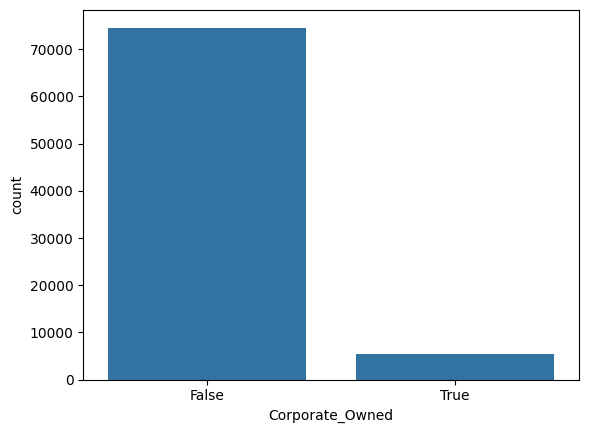

In [99]:
sns.countplot(x='Corporate_Owned', data=df, order=sorted(df['Corporate_Owned'].dropna().unique()))
plt.show()

In [100]:
df.corr()['Corporate_Owned'].sort_values()

Building_Class          -0.14
NU_Code                 -0.10
Sq_Ft                   -0.08
Recorded_Taxes          -0.06
Calculated_Taxes        -0.06
Yr_Built                -0.05
Building_Assmnt_2       -0.05
Building_Assmnt_1       -0.04
lat                     -0.04
Total_Rooms             -0.03
Year_1                  -0.02
Year_2                  -0.02
Total_Assmnt_2          -0.02
Total_Assmnt_1          -0.01
TaxRatio                -0.01
TotalUnits               0.00
Land_Assmnt_2            0.01
Land_Assmnt_1            0.01
Sale_Month               0.02
Sale_Price               0.06
lng                      0.07
TaxRate                  0.08
No_Of_Dwellings          0.12
Sale_Year                0.17
updated_at               0.19
Absentee                 0.25
Corporate_Owned          1.00
Property_Class            NaN
RateYear                  NaN
RatioYear                 NaN
Recorded_Taxes_Year       NaN
Calculated_Taxes_Year     NaN
County                    NaN
Name: Corp

There appear to be strong enough correlations between absentee, number of dwellings, building class and corporate owned.  We can impute the missing data based on an average across these features.

In [101]:
avg_corp_owned = df[df['Corporate_Owned'].notna()].groupby(['Absentee', 'No_Of_Dwellings',
                                                            'Building_Class']).agg({'Corporate_Owned': 'mean'}).reset_index()
avg_corp_owned_dwell = df[df['Corporate_Owned'].notna()].groupby(['Absentee', 'No_Of_Dwellings']).agg({'Corporate_Owned': 'mean'}).reset_index()
avg_corp_owned_absent = df[df['Corporate_Owned'].notna()].groupby(['Absentee']).agg({'Corporate_Owned': 'mean'}).reset_index()
def fill_corporate_owned(absentee, no_dwell, bld_cls, corp_owned):
    if np.isnan(corp_owned):
        result = 0
        segment = avg_corp_owned[(avg_corp_owned['Absentee'] == absentee) &
                                 (avg_corp_owned['No_Of_Dwellings'] == no_dwell) &
                                 (avg_corp_owned['Building_Class'] == bld_cls)]
        if segment.empty:
            segment = avg_corp_owned_dwell[(avg_corp_owned_dwell['Absentee'] == absentee) &
                                           (avg_corp_owned_dwell['No_Of_Dwellings'] == no_dwell)]
        if segment.empty:
            segment = avg_corp_owned_absent[(avg_corp_owned_absent['Absentee'] == absentee)]  
        if not segment.empty:
            result = segment.mean()['Corporate_Owned']
        return round(result)
    else:
        return corp_owned

In [102]:
df['Corporate_Owned'] = df.apply(lambda x: fill_corporate_owned(x['Absentee'], x['No_Of_Dwellings'],
                                                                x['Building_Class'], x['Corporate_Owned']), axis=1)

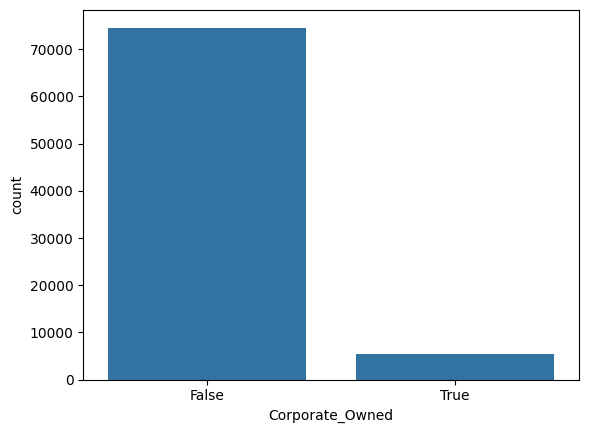

In [103]:
sns.countplot(x='Corporate_Owned', data=df, order=sorted(df['Corporate_Owned'].unique()))
plt.show()

## Sale Month / Year
Let's take a look at the values and see if there's a strong correlation to any other features.

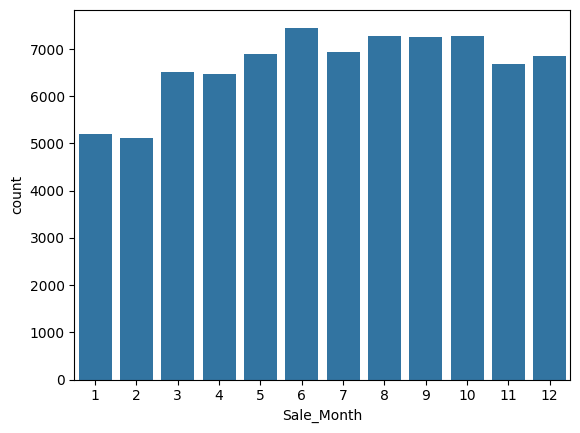

In [104]:
sns.countplot(x='Sale_Month', data=df, order=sorted(df['Sale_Month'].dropna().unique()))
plt.show()

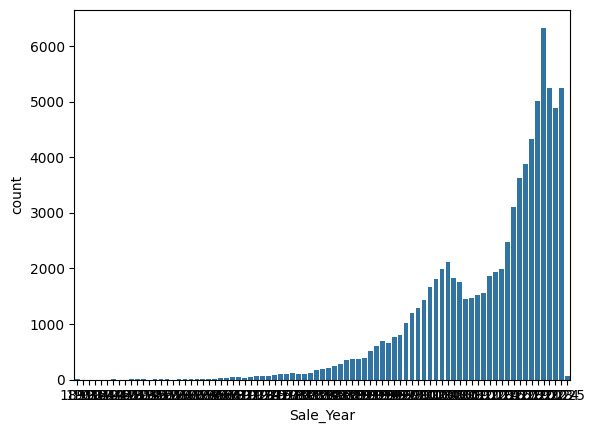

In [105]:
sns.countplot(x='Sale_Year', data=df, order=sorted(df['Sale_Year'].dropna().unique()))
plt.show()

In [106]:
df.corr()['Sale_Month'].sort_values()

No_Of_Dwellings         -0.01
Total_Rooms             -0.01
TaxRatio                -0.01
Sale_Year               -0.00
lat                     -0.00
Year_1                  -0.00
Year_2                  -0.00
Sq_Ft                    0.00
Yr_Built                 0.00
Building_Class           0.01
Building_Assmnt_1        0.01
Absentee                 0.01
TaxRate                  0.01
TotalUnits               0.01
Building_Assmnt_2        0.01
Recorded_Taxes           0.01
Calculated_Taxes         0.01
NU_Code                  0.01
Total_Assmnt_1           0.01
Total_Assmnt_2           0.01
Land_Assmnt_1            0.01
Land_Assmnt_2            0.01
lng                      0.01
updated_at               0.02
Corporate_Owned          0.02
Sale_Price               0.04
Sale_Month               1.00
Property_Class            NaN
RateYear                  NaN
RatioYear                 NaN
Recorded_Taxes_Year       NaN
Calculated_Taxes_Year     NaN
County                    NaN
Name: Sale

In [107]:
df.corr()['Sale_Year'].sort_values()

NU_Code                 -0.27
lat                     -0.08
TaxRate                 -0.03
Sq_Ft                   -0.02
Year_2                  -0.02
Year_1                  -0.02
Yr_Built                -0.01
Building_Class          -0.01
Total_Rooms             -0.01
Sale_Month              -0.00
TaxRatio                 0.01
Land_Assmnt_2            0.01
Land_Assmnt_1            0.01
Calculated_Taxes         0.02
Recorded_Taxes           0.02
Total_Assmnt_2           0.03
No_Of_Dwellings          0.03
Total_Assmnt_1           0.03
Building_Assmnt_2        0.04
TotalUnits               0.04
Building_Assmnt_1        0.05
lng                      0.08
updated_at               0.09
Absentee                 0.16
Corporate_Owned          0.17
Sale_Price               0.19
Sale_Year                1.00
Property_Class            NaN
RateYear                  NaN
RatioYear                 NaN
Recorded_Taxes_Year       NaN
Calculated_Taxes_Year     NaN
County                    NaN
Name: Sale

There's very little correlations between other features and sale month / year and there are very few records missing the sale month / year data.  Therefore we will remove the rows missing sales month / year from our data set.

In [108]:
df = df.dropna(subset=['Sale_Month', 'Sale_Year'])

## Check Status of Missing Data

In [109]:
100 * df.isnull().sum() / len(df)

lat                     0.00
lng                     0.00
No_Of_Dwellings         0.00
Corporate_Owned         0.00
Absentee                0.00
NU_Code                 0.00
updated_at              0.00
TotalUnits              0.00
Sq_Ft                   0.00
Property_Class          0.00
Building_Class          0.00
Yr_Built                0.00
TaxRate                 0.00
TaxRatio                0.00
RateYear                0.00
RatioYear               0.00
Recorded_Taxes          0.00
Recorded_Taxes_Year     0.00
Calculated_Taxes        0.00
Calculated_Taxes_Year   0.00
Year_1                  0.00
Land_Assmnt_1           0.00
Building_Assmnt_1       0.00
Total_Assmnt_1          0.00
Year_2                  0.00
Land_Assmnt_2           0.00
Building_Assmnt_2       0.00
Total_Assmnt_2          0.00
Total_Rooms             0.00
Sale_Price              0.00
County                  0.00
Sale_Month              0.00
Sale_Year               0.00
dtype: float64

# Finalize Features
Now we need to decide how we're going to structure our data, the vector input, that we will feed into our model.

## Calculated Taxes and Year
This information is embedded in the recorded taxes and is not needed, therefore we will drop the columns from our data set.

In [110]:
df = df.drop(['Calculated_Taxes', 'Calculated_Taxes_Year'], axis=1)

## County
We'll convert this into a category and then transpose the data into dummy columns, essentially a bitmap.

In [111]:
df['County'].value_counts()

County
1    79973
Name: count, dtype: int64

In [112]:
df['County'] = df['County'].map({
    1: 'Atlantic',
    2: 'Bergen',
    3: 'Burlignton',
    4: 'Camden',
    5: 'Cape May',
    6: 'Cumberland',
    7: 'Essex',
    8: 'Gloucester',
    9: 'Hudson',
    10: 'Hunterdon',
    11: 'Mercer',
    12: 'Middlesex',
    13: 'Monmouth',
    14: 'Morris',
    15: 'Ocean',
    16: 'Passaic',
    17: 'Salem',
    18: 'Somerset',
    19: 'Sussex',
    20: 'Union',
    21: 'Warren'
})
df['County'].value_counts()

County
Atlantic    79973
Name: count, dtype: int64

In [113]:
dummies = pd.get_dummies(df['County'])
df = df.drop('County', axis=1)
# in case sample data is missing a county, we'll add
# the columns manually and then overwrite the values
# skip Atlantic because we want to drop one column
counties = ['Bergen', 'Burlignton', 'Camden', 'Cape May',
            'Cumberland', 'Essex', 'Gloucester', 'Hudson',
            'Hunterdon', 'Mercer', 'Middlesex', 'Monmouth',
            'Morris', 'Ocean', 'Passaic', 'Salem', 'Somerset',
            'Sussex', 'Union', 'Warren']
for county in counties:
    if county in dummies.columns:
        df[county] = dummies[county]
    else:
        df[county] = False

## NU Code
There's too much uncertainty around property values where an NU Code is applied, so we'll drop those records and remove this column from our data set.

In [114]:
df = df[df['NU_Code'] == 99]
df = df.drop('NU_Code', axis=1)

In [115]:
# df['NU_Code'].value_counts()

In [116]:
# df['NU_Code'] = df['NU_Code'].map({
#     99: 'None',
#     -1: 'Unknown',
#     0: 'Unknown',
#     1: 'immediate family',
#     2: 'love and affection',
#     3: 'corporation',
#     4: 'convenience',
#     5: 'transfer',
#     6: 'apportionment',
#     7: 'subsequent to assessment',
#     8: 'undivided interest',
#     9: 'governmental lien',
#     10: 'trustees',
#     11: 'judicial',
#     12: 'sheriff',
#     13: 'benefit of creditors',
#     14: 'doubtful title',
#     15: 'political',
#     16: 'more than one taxing district',
#     17: 'charitable',
#     18: 'foreclosure',
#     19: 'physical damage',
#     20: 'right-of-way',
#     21: 'affordable housing',
#     22: 'exchange',
#     23: 'industrial',
#     24: 'influenced',
#     25: 'realty transfer fee act',
#     26: 'not compelled',
#     27: 'reassessment',
#     28: 'leaseback',
#     29: 'freeze act',
#     30: 'package deal',
#     31: 'federal or state',
#     32: 'building omitted',
#     33: 'exempt property'
# })
# df['NU_Code'].value_counts()

In [117]:
# dummies = pd.get_dummies(df['NU_Code'], drop_first=True)
# df = df.drop('NU_Code', axis=1)
# df = pd.concat([df, dummies], axis=1)

## Property Class
Since our model is only for residential properties we can remove this column.

In [118]:
df = df.drop('Property_Class', axis=1)

## Ratio Year / Recorded Taxes Year
This information doesn't vary between records and doesn't have a very strong correlation with sales price, therefore we can drop the column.

In [119]:
df = df.drop(['RatioYear', 'Recorded_Taxes_Year'], axis=1)

## Total Rooms
And we are no longer using total rooms in our analysis due to inconsistencies in the data being available across all the files, we we'll drop the column

In [120]:
df = df.drop('Total_Rooms', axis=1)

## Total Units
This data seems to have very little impact on sales price for residential homes and therefore we will drop the column.

In [121]:
df = df.drop('TotalUnits', axis=1)

## Year 1 / Year 2
These should really be int values.

In [122]:
df['Year_1'] = df['Year_1'].astype(int)
df['Year_2'] = df['Year_2'].astype(int)

## Year 2 Assessments
This information is closely related to year 1 assessments and therefore we will ignore it for training purposes.

In [123]:
df = df.drop(['Year_2', 'Land_Assmnt_2', 'Building_Assmnt_2', 'Total_Assmnt_2'], axis=1)

## Review and Save the Dataframe
Now we can store our data set that will be used to train and test our model.

In [124]:
print(df.shape)
df

(35148, 40)


,lat,lng,No_Of_Dwellings,Corporate_Owned,Absentee,updated_at,Sq_Ft,Building_Class,Yr_Built,TaxRate,TaxRatio,RateYear,Recorded_Taxes,Year_1,Land_Assmnt_1,Building_Assmnt_1,Total_Assmnt_1,Sale_Price,Sale_Month,Sale_Year,Bergen,Burlignton,Camden,Cape May,Cumberland,Essex,Gloucester,Hudson,Hunterdon,Mercer,Middlesex,Monmouth,Morris,Ocean,Passaic,Salem,Somerset,Sussex,Union,Warren
369,39.32,-74.59,1,False,2,1738515772000,528,15,1946,3.58,67.77,2024,"5,205.00",2025,124900,25100,150000,"39,000.00",5,1989,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
372,39.32,-74.59,1,False,2,1738515772000,815,16,1921,3.58,67.77,2024,"4,684.50",2025,89800,45200,135000,"119,000.00",2,2001,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
375,39.32,-74.59,1,False,1,1738515772000,1051,16,1907,3.58,67.77,2024,"7,526.43",2025,89800,127100,216900,"205,000.00",7,2021,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
385,39.32,-74.59,1,False,0,1738515772000,960,16,1950,3.58,67.77,2024,"5,555.31",2025,79400,87900,167300,"136,000.00",11,2003,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
386,39.32,-74.59,1,False,0,1738515772000,434,12,1940,3.58,67.77,2024,"2,616.38",2025,59300,16100,75400,"125,000.00",2,2020,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146772,39.34,-74.47,1,True,2,1738515772000,1510,15,1974,2.73,66.22,2024,"11,857.42",2025,360000,85600,445600,"575,000.00",12,2006,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
146781,39.34,-74.47,1,False,2,1738515772000,1510,15,1974,2.73,66.22,2024,"6,822.80",2025,170000,86400,256400,"410,000.00",1,2018,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
146782,39.34,-74.47,1,False,2,1738515772000,1510,15,1974,2.73,66.22,2024,"8,930.32",2025,250000,85600,335600,"495,000.00",2,2016,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
146786,39.34,-74.47,1,False,2,1738515772000,997,15,1974,2.73,66.22,2024,"5,601.41",2025,150000,60500,210500,"289,500.00",8,2020,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [125]:
df.to_pickle('data/sample/processed.pkl')

In [126]:
test = pd.read_pickle('data/sample/processed.pkl')
print(test.shape)
test

(35148, 40)


,lat,lng,No_Of_Dwellings,Corporate_Owned,Absentee,updated_at,Sq_Ft,Building_Class,Yr_Built,TaxRate,TaxRatio,RateYear,Recorded_Taxes,Year_1,Land_Assmnt_1,Building_Assmnt_1,Total_Assmnt_1,Sale_Price,Sale_Month,Sale_Year,Bergen,Burlignton,Camden,Cape May,Cumberland,Essex,Gloucester,Hudson,Hunterdon,Mercer,Middlesex,Monmouth,Morris,Ocean,Passaic,Salem,Somerset,Sussex,Union,Warren
369,39.32,-74.59,1,False,2,1738515772000,528,15,1946,3.58,67.77,2024,"5,205.00",2025,124900,25100,150000,"39,000.00",5,1989,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
372,39.32,-74.59,1,False,2,1738515772000,815,16,1921,3.58,67.77,2024,"4,684.50",2025,89800,45200,135000,"119,000.00",2,2001,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
375,39.32,-74.59,1,False,1,1738515772000,1051,16,1907,3.58,67.77,2024,"7,526.43",2025,89800,127100,216900,"205,000.00",7,2021,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
385,39.32,-74.59,1,False,0,1738515772000,960,16,1950,3.58,67.77,2024,"5,555.31",2025,79400,87900,167300,"136,000.00",11,2003,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
386,39.32,-74.59,1,False,0,1738515772000,434,12,1940,3.58,67.77,2024,"2,616.38",2025,59300,16100,75400,"125,000.00",2,2020,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146772,39.34,-74.47,1,True,2,1738515772000,1510,15,1974,2.73,66.22,2024,"11,857.42",2025,360000,85600,445600,"575,000.00",12,2006,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
146781,39.34,-74.47,1,False,2,1738515772000,1510,15,1974,2.73,66.22,2024,"6,822.80",2025,170000,86400,256400,"410,000.00",1,2018,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
146782,39.34,-74.47,1,False,2,1738515772000,1510,15,1974,2.73,66.22,2024,"8,930.32",2025,250000,85600,335600,"495,000.00",2,2016,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
146786,39.34,-74.47,1,False,2,1738515772000,997,15,1974,2.73,66.22,2024,"5,601.41",2025,150000,60500,210500,"289,500.00",8,2020,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
